# Avaliação Sprint 3 - Análise sentimental de artigos com SpaCy
## Autor: João Victor Palhares Barbosa

#### Objetivo dessa avaliação:
- Capturar sentimentos de uma base de dados do Twitter, e classificar os sentimentos dos artigos jornalísticos de 50 anos atrás da Folha de S.Paulo (https://www1.folha.uol.com.br/especial/2017/ha-50-anos/)

#### Essa avaliação tem o intuito de pontuar:
- I. Extrair 10 artigos jornalísticos
- II. A partir de cada artigo, armazenar os textos no mongoDB
- III. Criar uma nuvem de palavras para cada artigo
- IV. Listar verbos e entidades utilizadas
- V. Analisar sentimentos das frases dos artigos
- VI. Armazenar resultados das análises no mongoDB

### 1.0 Importando bibliotecas e atribuindo o modelo brasileiro do SpaCy

In [1]:
# importando bibliotecas

import json
import spacy
import pymongo
import numpy as np
import pandas as pd
from sklearn import svm
from spacy import displacy
from sklearn import metrics
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen
from wordcloud import WordCloud, STOPWORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
#!python3 -m spacy download pt_core_news_sm

In [3]:
# baixando o modelo do SpaCy - pt-br

nlp = spacy.load("pt_core_news_sm")

### 1.1 Atribuindo todas as URLs dos artigos da Folha de S.Paulo

In [4]:
url = {}
url[0] = "https://www1.folha.uol.com.br/banco-de-dados/2021/05/1971-prefeito-revoga-decreto-que-previa-quarteirao-verde-no-jardim-paulista.shtml"
url[1] = "https://www1.folha.uol.com.br/banco-de-dados/2021/04/1971-governador-diz-conversar-com-prefeito-de-sao-paulo-diariamente.shtml"
url[2] = "https://www1.folha.uol.com.br/banco-de-dados/2021/04/1971-vicente-matheus-e-escolhido-para-ser-diretor-de-futebol-do-corinthians.shtml"
url[3] = "https://www1.folha.uol.com.br/banco-de-dados/2021/04/1971-vaticano-afirma-que-paises-pobres-recebem-quantia-ridicula-de-ajuda.shtml"
url[4] = "https://www1.folha.uol.com.br/banco-de-dados/2021/04/1971-india-fala-em-matanca-e-ameaca-intervir-para-ajudar-bangladesh.shtml"
url[5] = "https://www1.folha.uol.com.br/banco-de-dados/2021/04/1971-nixon-cede-a-clamor-ao-libertar-condenado-por-massacre-em-my-lai.shtml"
url[6] = "https://www1.folha.uol.com.br/banco-de-dados/2021/01/1971-piloto-italiano-morre-apos-ferrari-explodir-em-batida-na-argentina.shtml"
url[7] = "https://www1.folha.uol.com.br/banco-de-dados/2021/03/1971-a-grande-cidade-corinthians-vai-as-urnas-30-mil-podem-votar.shtml"
url[8] = "https://www1.folha.uol.com.br/banco-de-dados/2021/03/1971-crise-entre-militares-na-cupula-do-governo-argentino-se-agrava.shtml"
url[9] = "https://www1.folha.uol.com.br/banco-de-dados/2021/03/1971-primeiro-ministro-do-canada-se-casa-em-segredo.shtml"

### 2.0 Funções para o tratamento dos artigos
- Baixando os sites, scraping de títulos e artigos, limpando espaços vazios e quebras de linhas e transformando os dados em json para a futura inserção no banco de dados

In [5]:
# essa função irá tratar o texto, re-ajustando os espaços entre as TAGS

def tratamento_texto(input):
    " ".join(input.split()).replace('> <', '><')
    return BeautifulSoup(input, 'html.parser')

In [6]:
# essa função irá capturar os titulos vindo do scrap
# o list comprehension irá manipular o título, limpando o \n e espaços indesejados

def cria_titulo(input):
    titulo = input.find('h1', {'class':'c-content-head__title'}).get_text()
    titulo = "".join(titulo.strip() for linha in range(len(titulo.split("\n")) -2))
    return titulo

In [7]:
# essa função irá capturar os artigos vindo do scrap
# também é removido \n, espaços e informações repetidas

def cria_artigo(input):
    artigo = input.find('div', {'class': 'c-news__body'}).get_text()
    artigo = artigo.replace('\n', ' ').replace('\r', '').replace('  ', '').replace('Primeira Página da Folha de', '').replace('- Reprodução', '')
    return artigo

In [8]:
# função para baixar todo o conteúdo do site e converter em utf-8

def baixa_site(input):
    contexto = urlopen(url[i])
    siteCompleto = contexto.read()
    return siteCompleto.decode('utf-8')

In [9]:
# essa função irá capturar o título e o artigo, transformando tudo em apenas 1 json para inserir no mongoDB
# essa função também é invocada para inserir no banco o título por sentimento

def transforma_json(titulo, artigo):
    conteudo = {}
    conteudo[titulo] = artigo
    jsonArray = json.dumps(conteudo, ensure_ascii = False)
    return conteudo

### 3.0 Função para salvar informações no mongoDB
- Essa função vai criar a conexão com o banco de dados mongoDB e irá retornar a coleção, para que seja inserido informações em JSON

In [10]:
# função padrão para salvar informações no mongoDB

def cria_db(input):
    meuCliente = pymongo.MongoClient("mongodb://localhost:27017/")
    meuDB = meuCliente["avaliacao"]
    return meuDB[str(input)]

### 4.0 Funções abaixo servem para manipular os textos
- Essas funções servem para tratar os dados capturados
- A função 'mostra_nuvem' retorna uma nuvem de palavras, assim que invocada, irá processar de acordo com o documento tratado através do NLP
- As funções 'cria_doc_tratado', 'cria_doc' e 'trata_texto' servem para processar a linguagem natural
- 'trata_texto' vai validar cada informação capturada no capítulo 2.0

In [11]:
# função para criar nuvem de palavras

def mostrar_nuvem(input):
    wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, collocations=False, stopwords = STOPWORDS).generate(str(input))
    plt.figure(figsize = (40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");

In [12]:
# essa função vai pegar o artigo na posição I, vai transformar para doc e tratar o texto, validando em stopwords e caracteres válidos

def cria_doc_tratado(input):
    return trata_texto(cria_doc(input))

In [13]:
# essa função serve para retornar o doc do NLP

def cria_doc(input):
    texto = str(input)
    doc = nlp(texto)
    return doc

In [14]:
# essa função vai tratar o texto, convertendo em palavras válidas: stopwords e caracteres alfabéticos

def trata_texto(doc):
  tokens_validos = []
  for token in doc:
    e_valido = not token.is_stop and token.is_alpha
    if e_valido:
      tokens_validos.append(token.text.lower())
  
  if len(tokens_validos) > 2:
    return " ".join(tokens_validos)

### 5.0 Célula principal do código
- A célula abaixo irá invocar as funções anteriores para baixar informações dos sites, selecionar título e artigo de cada URL, e salvar no banco de dados

In [15]:
# criando uma coleção, para inserir as informações no banco
# todos os dados serão divididos em títulos e textos de cada artigo, que por sua vez é inserido 1 por vez no banco de dados
# o JSON final do banco é {titulo:artigo}
# a variável 'textos_de_treino' possui todos os textos dos artigos em formato de lista, para a futura classificacao

minhaColecao = cria_db("artigos")

titulos_dos_textos = []
textos_de_treino = []

for i in range(len(url)):
    site = baixa_site(url[i])
    conteudo = transforma_json(cria_titulo(tratamento_texto(site)), cria_artigo(tratamento_texto(site)))
    insercaoNoBanco = minhaColecao.insert_one(conteudo)
    print("Inserindo o artigo " + url[i] + " no banco de dados")
    
    titulos_dos_textos.append(cria_titulo(tratamento_texto(site)))
    textos_de_treino.append(cria_artigo(tratamento_texto(site)))

Inserindo o artigo https://www1.folha.uol.com.br/banco-de-dados/2021/05/1971-prefeito-revoga-decreto-que-previa-quarteirao-verde-no-jardim-paulista.shtml no banco de dados
Inserindo o artigo https://www1.folha.uol.com.br/banco-de-dados/2021/04/1971-governador-diz-conversar-com-prefeito-de-sao-paulo-diariamente.shtml no banco de dados
Inserindo o artigo https://www1.folha.uol.com.br/banco-de-dados/2021/04/1971-vicente-matheus-e-escolhido-para-ser-diretor-de-futebol-do-corinthians.shtml no banco de dados
Inserindo o artigo https://www1.folha.uol.com.br/banco-de-dados/2021/04/1971-vaticano-afirma-que-paises-pobres-recebem-quantia-ridicula-de-ajuda.shtml no banco de dados
Inserindo o artigo https://www1.folha.uol.com.br/banco-de-dados/2021/04/1971-india-fala-em-matanca-e-ameaca-intervir-para-ajudar-bangladesh.shtml no banco de dados
Inserindo o artigo https://www1.folha.uol.com.br/banco-de-dados/2021/04/1971-nixon-cede-a-clamor-ao-libertar-condenado-por-massacre-em-my-lai.shtml no banco de

### 5.1 Criando uma nuvem de palavras para cada artigo

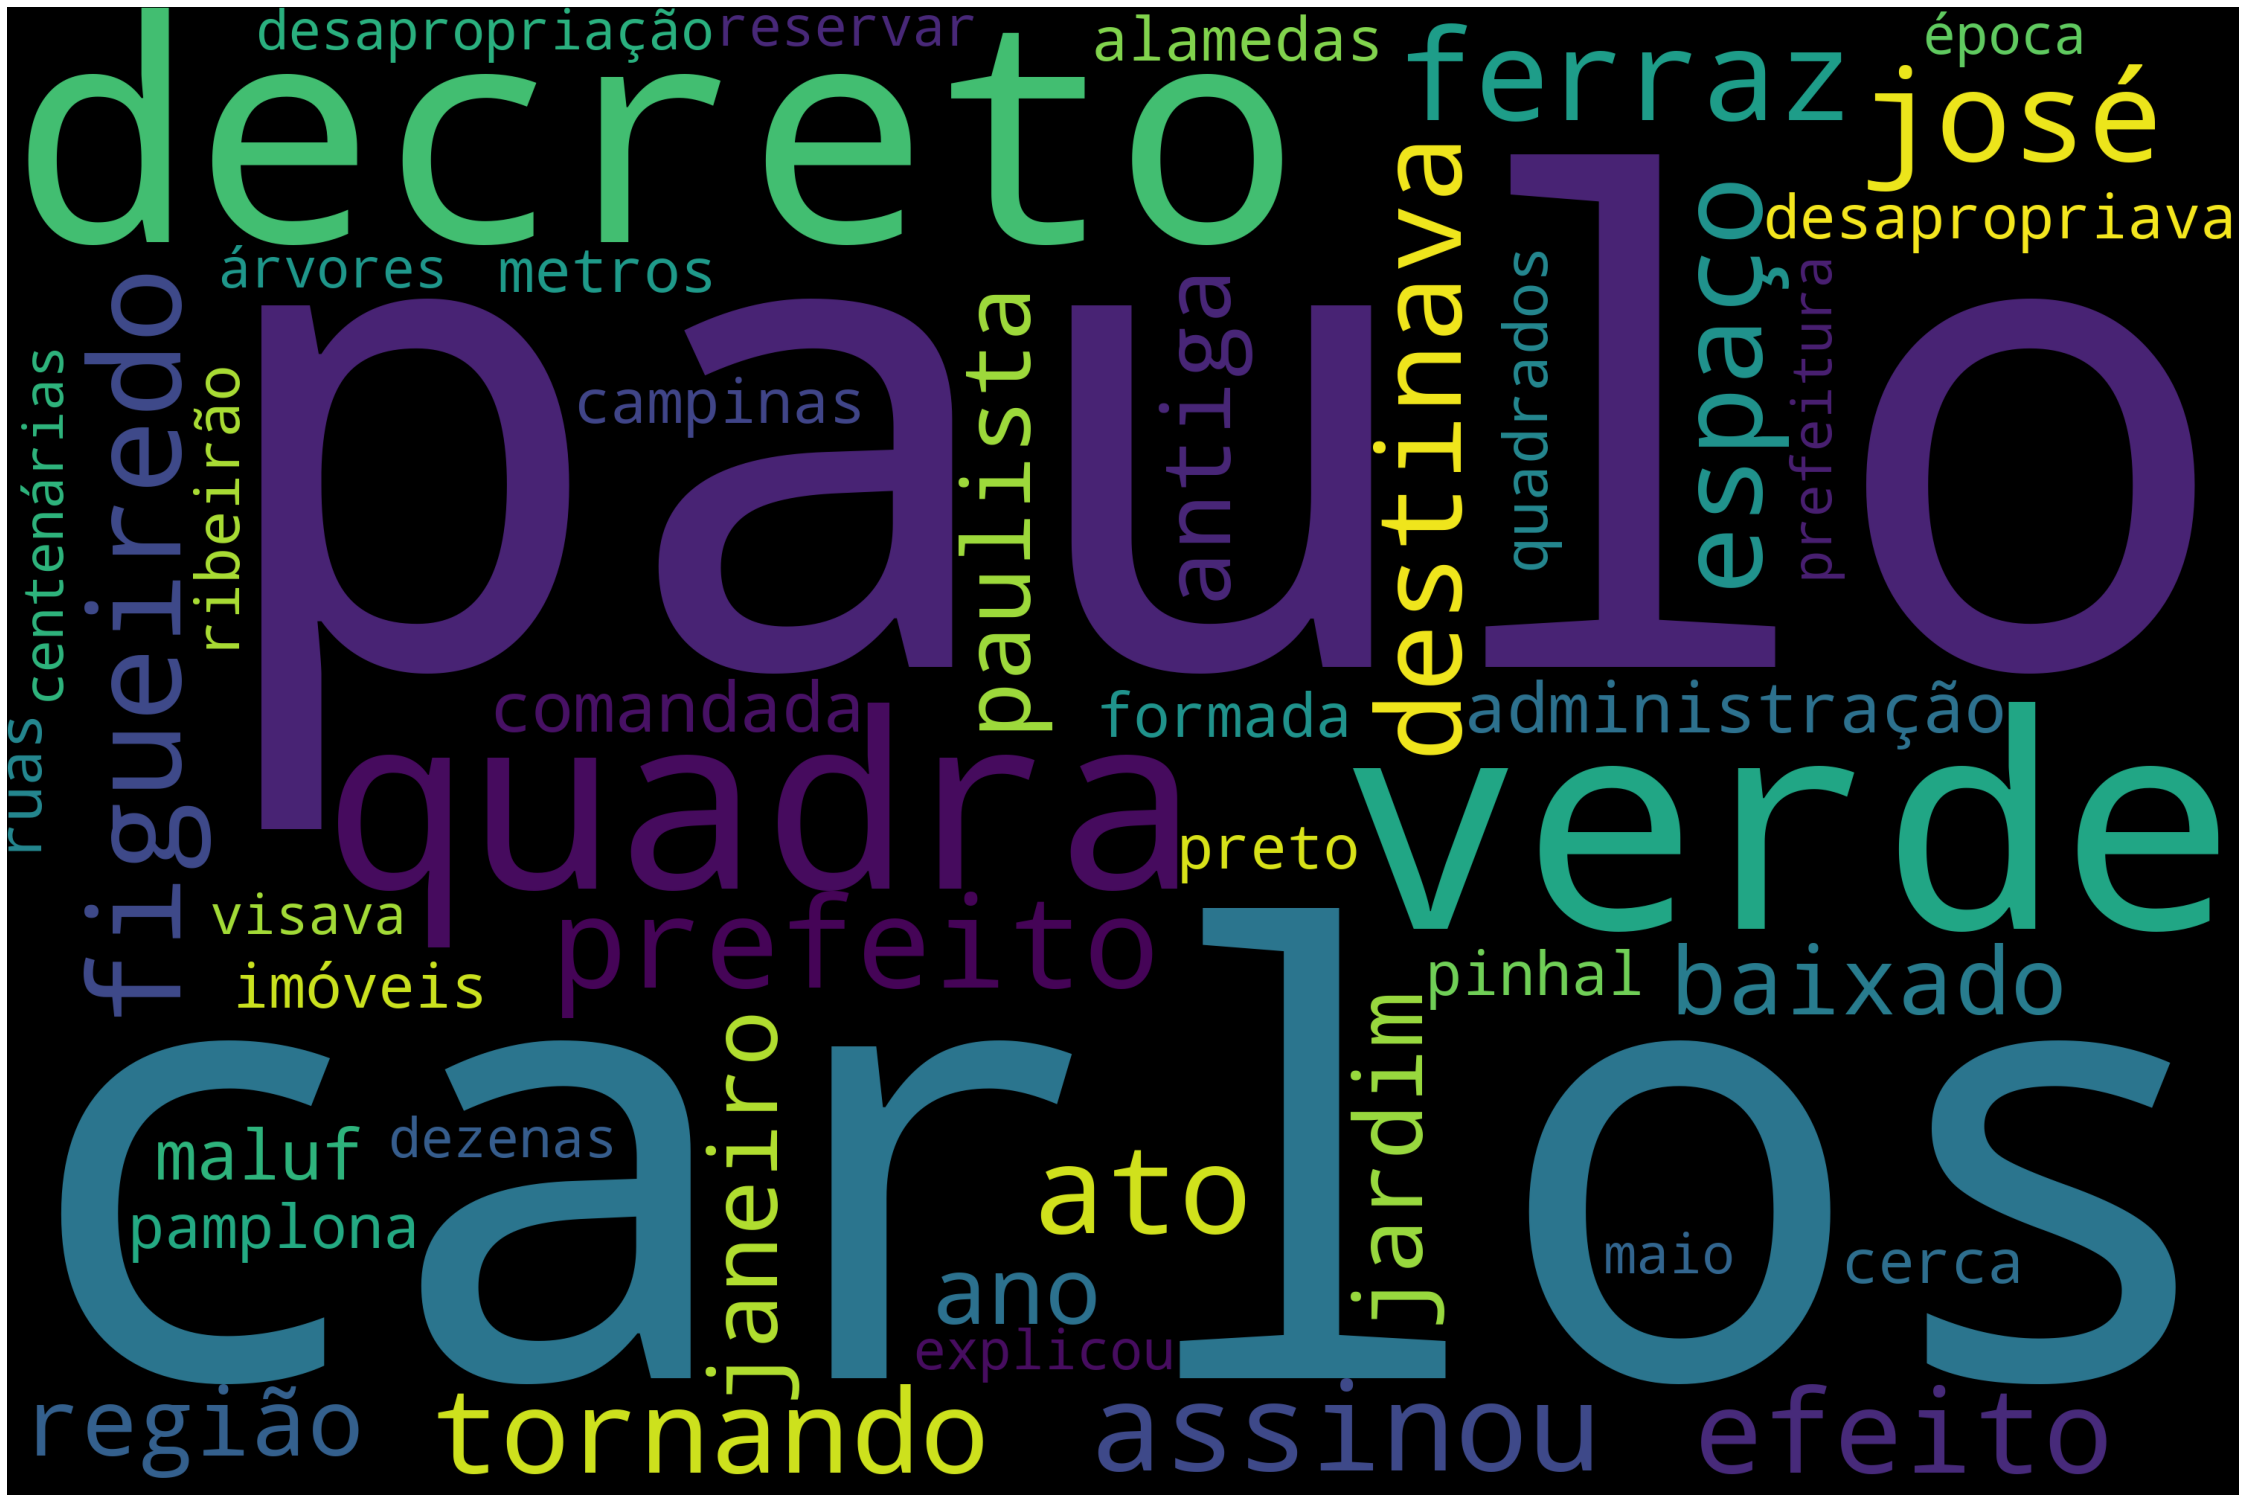

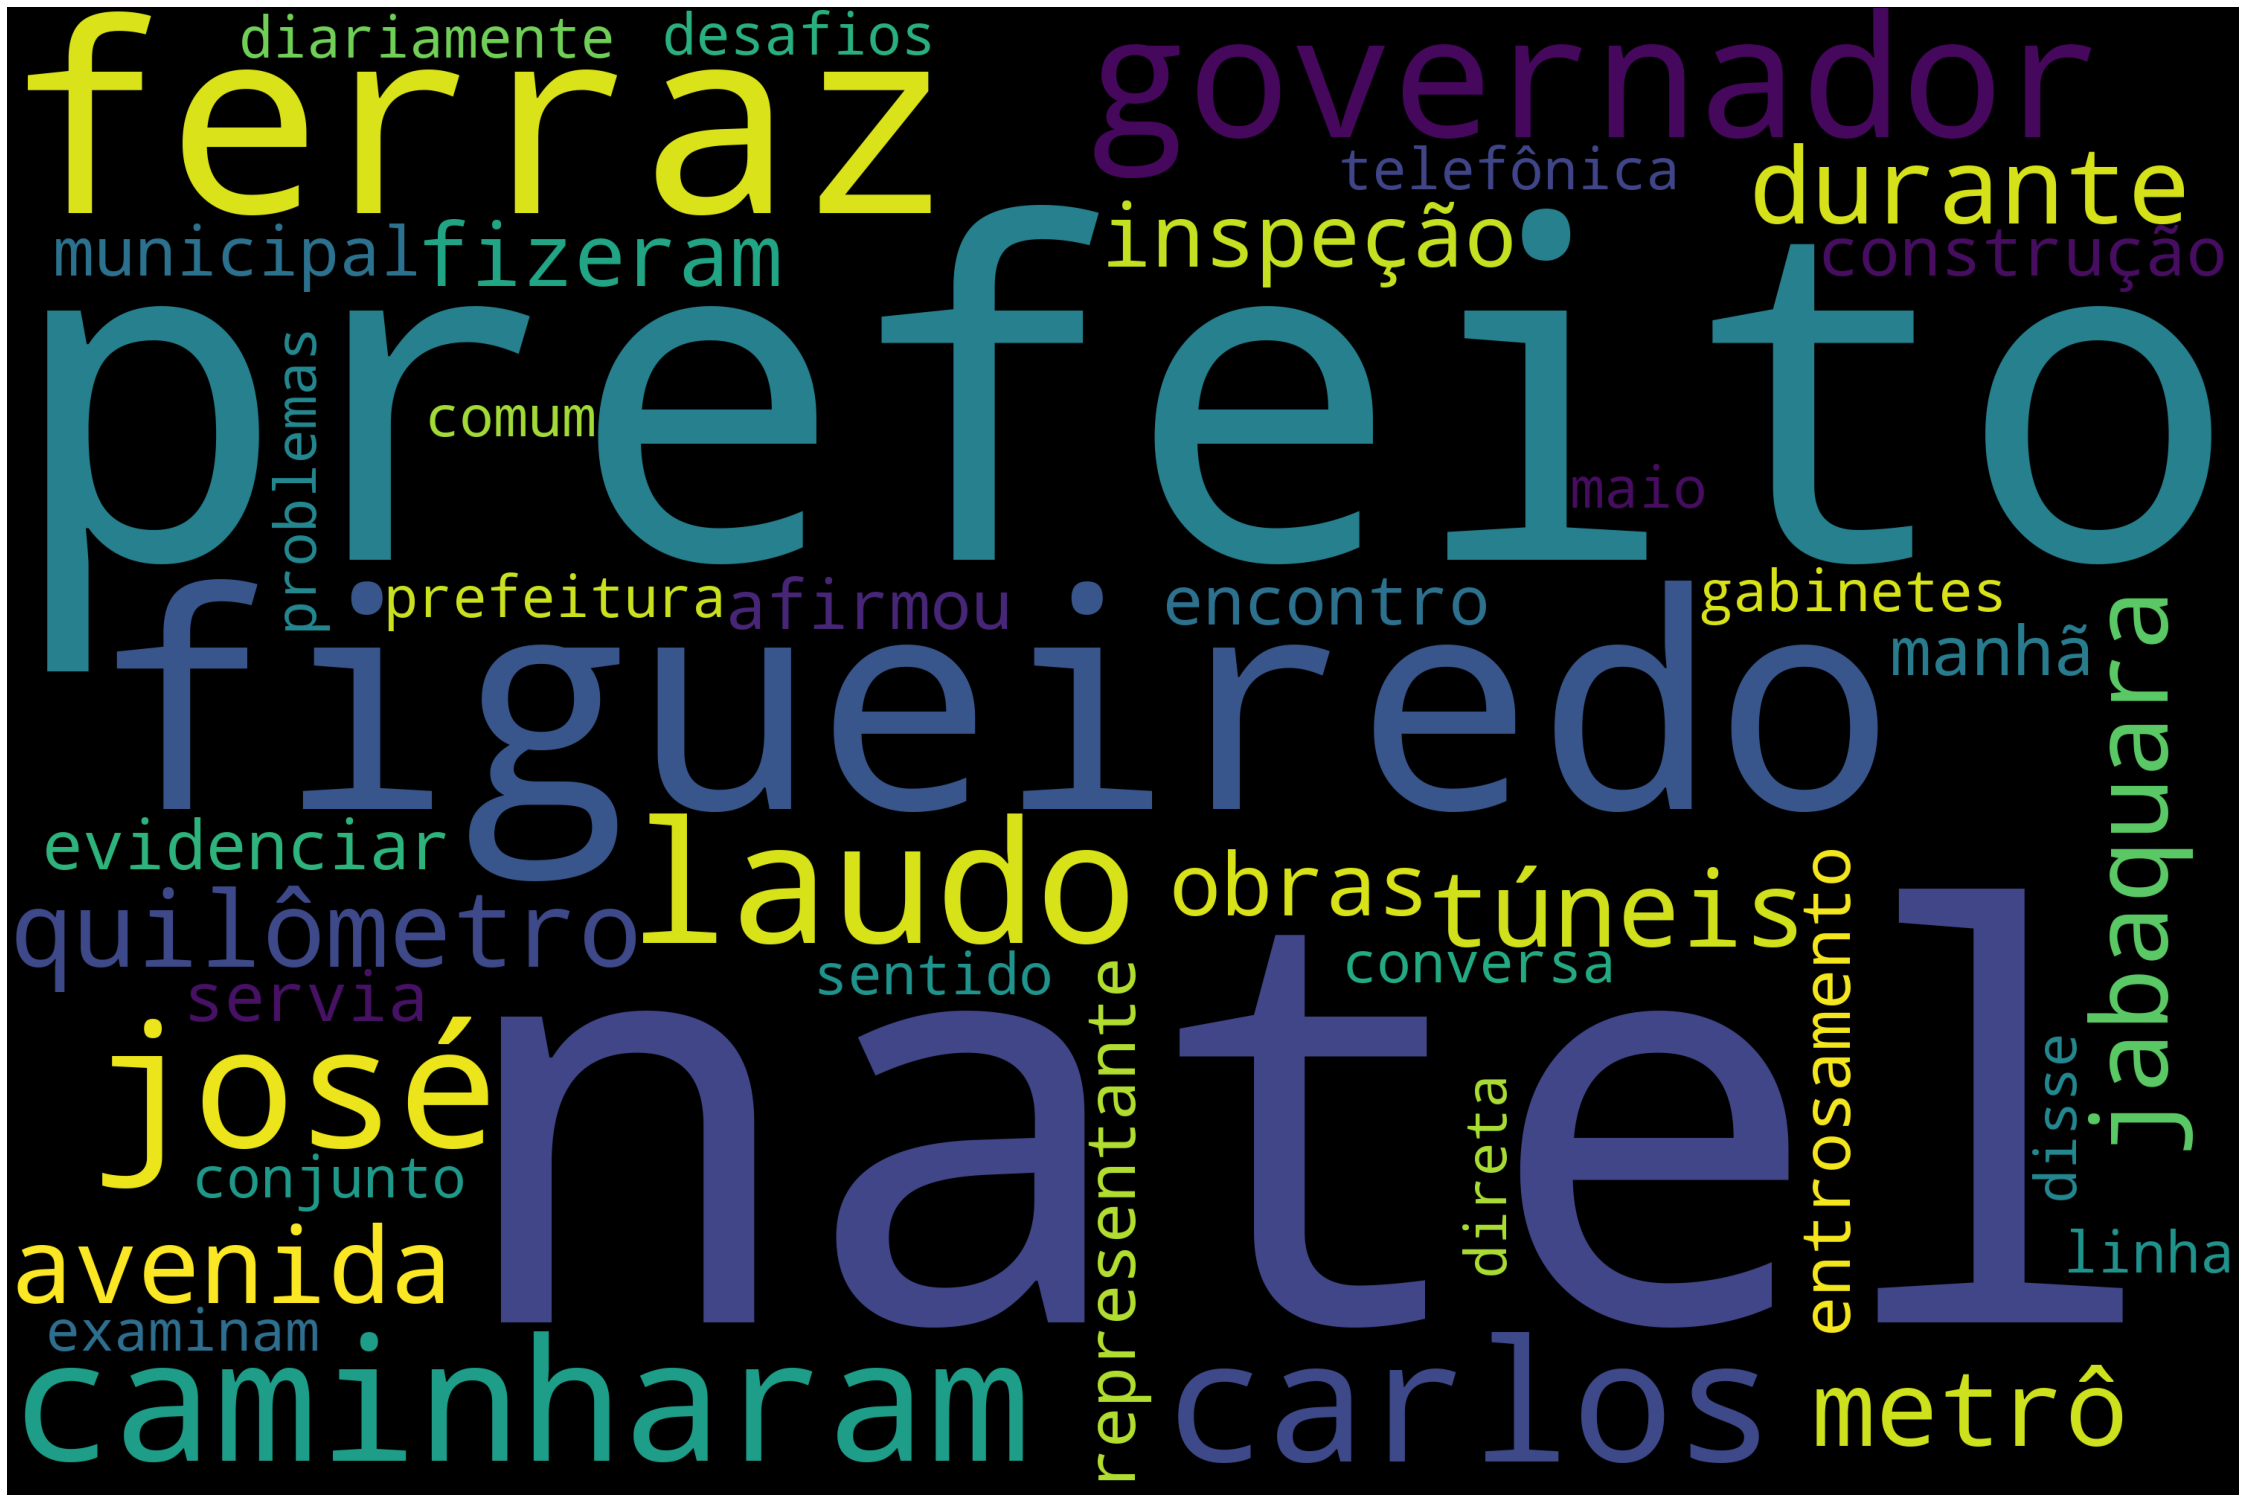

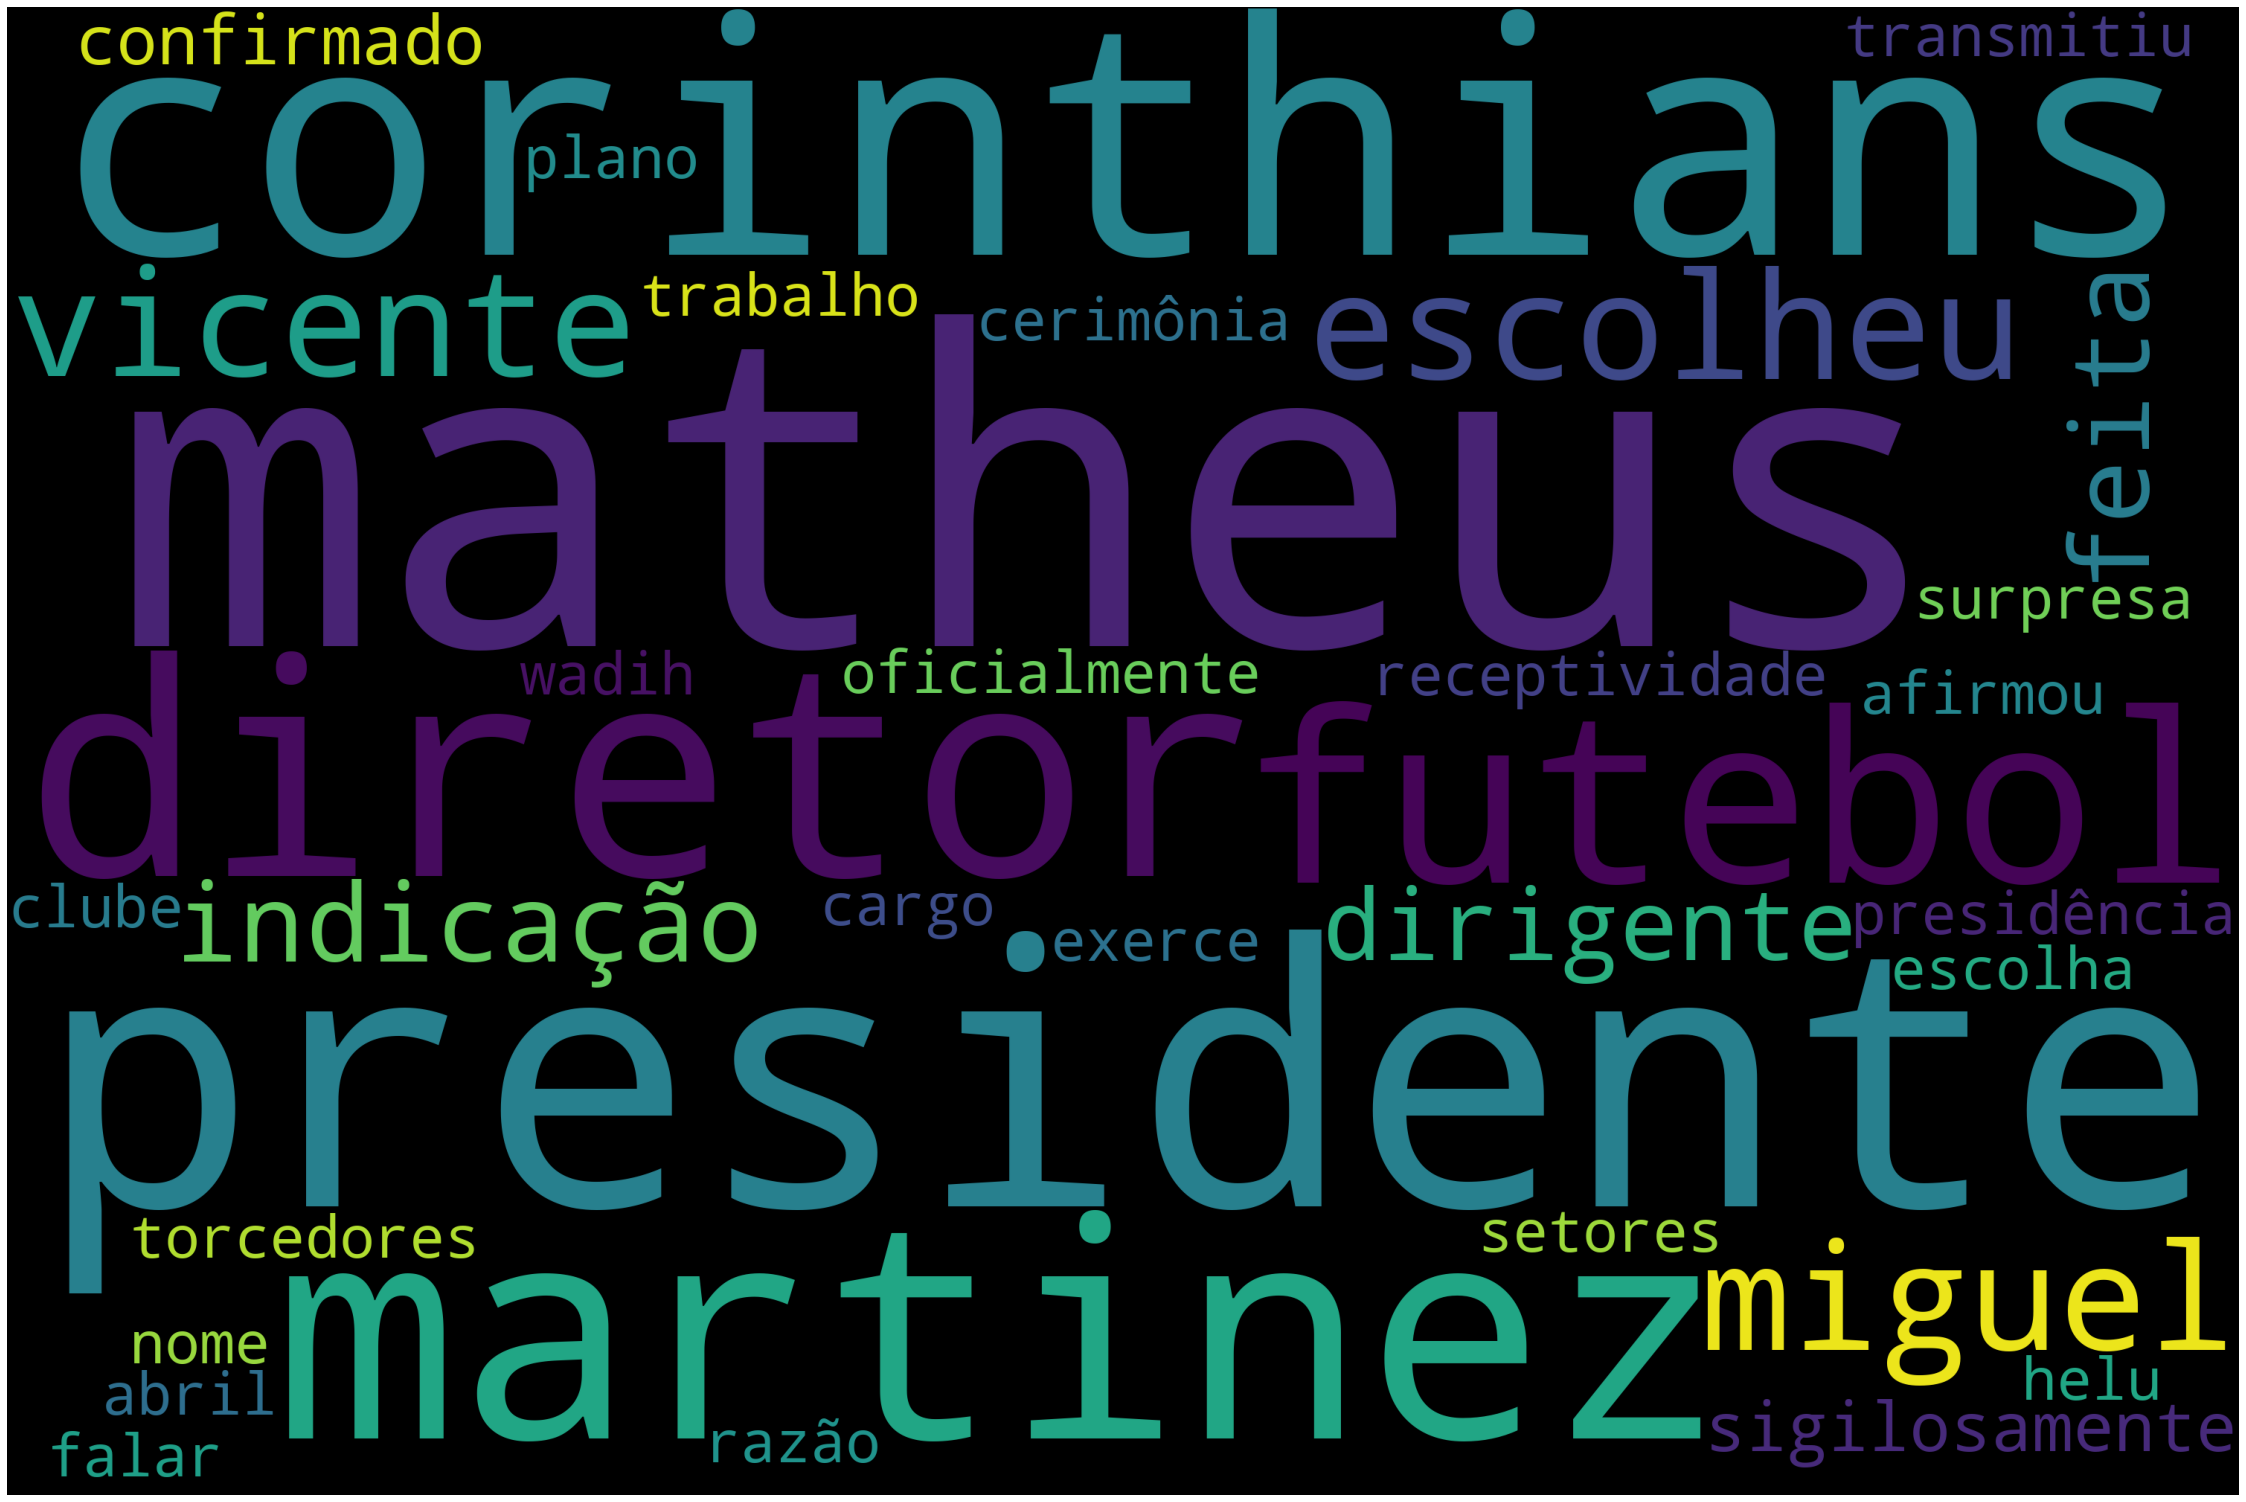

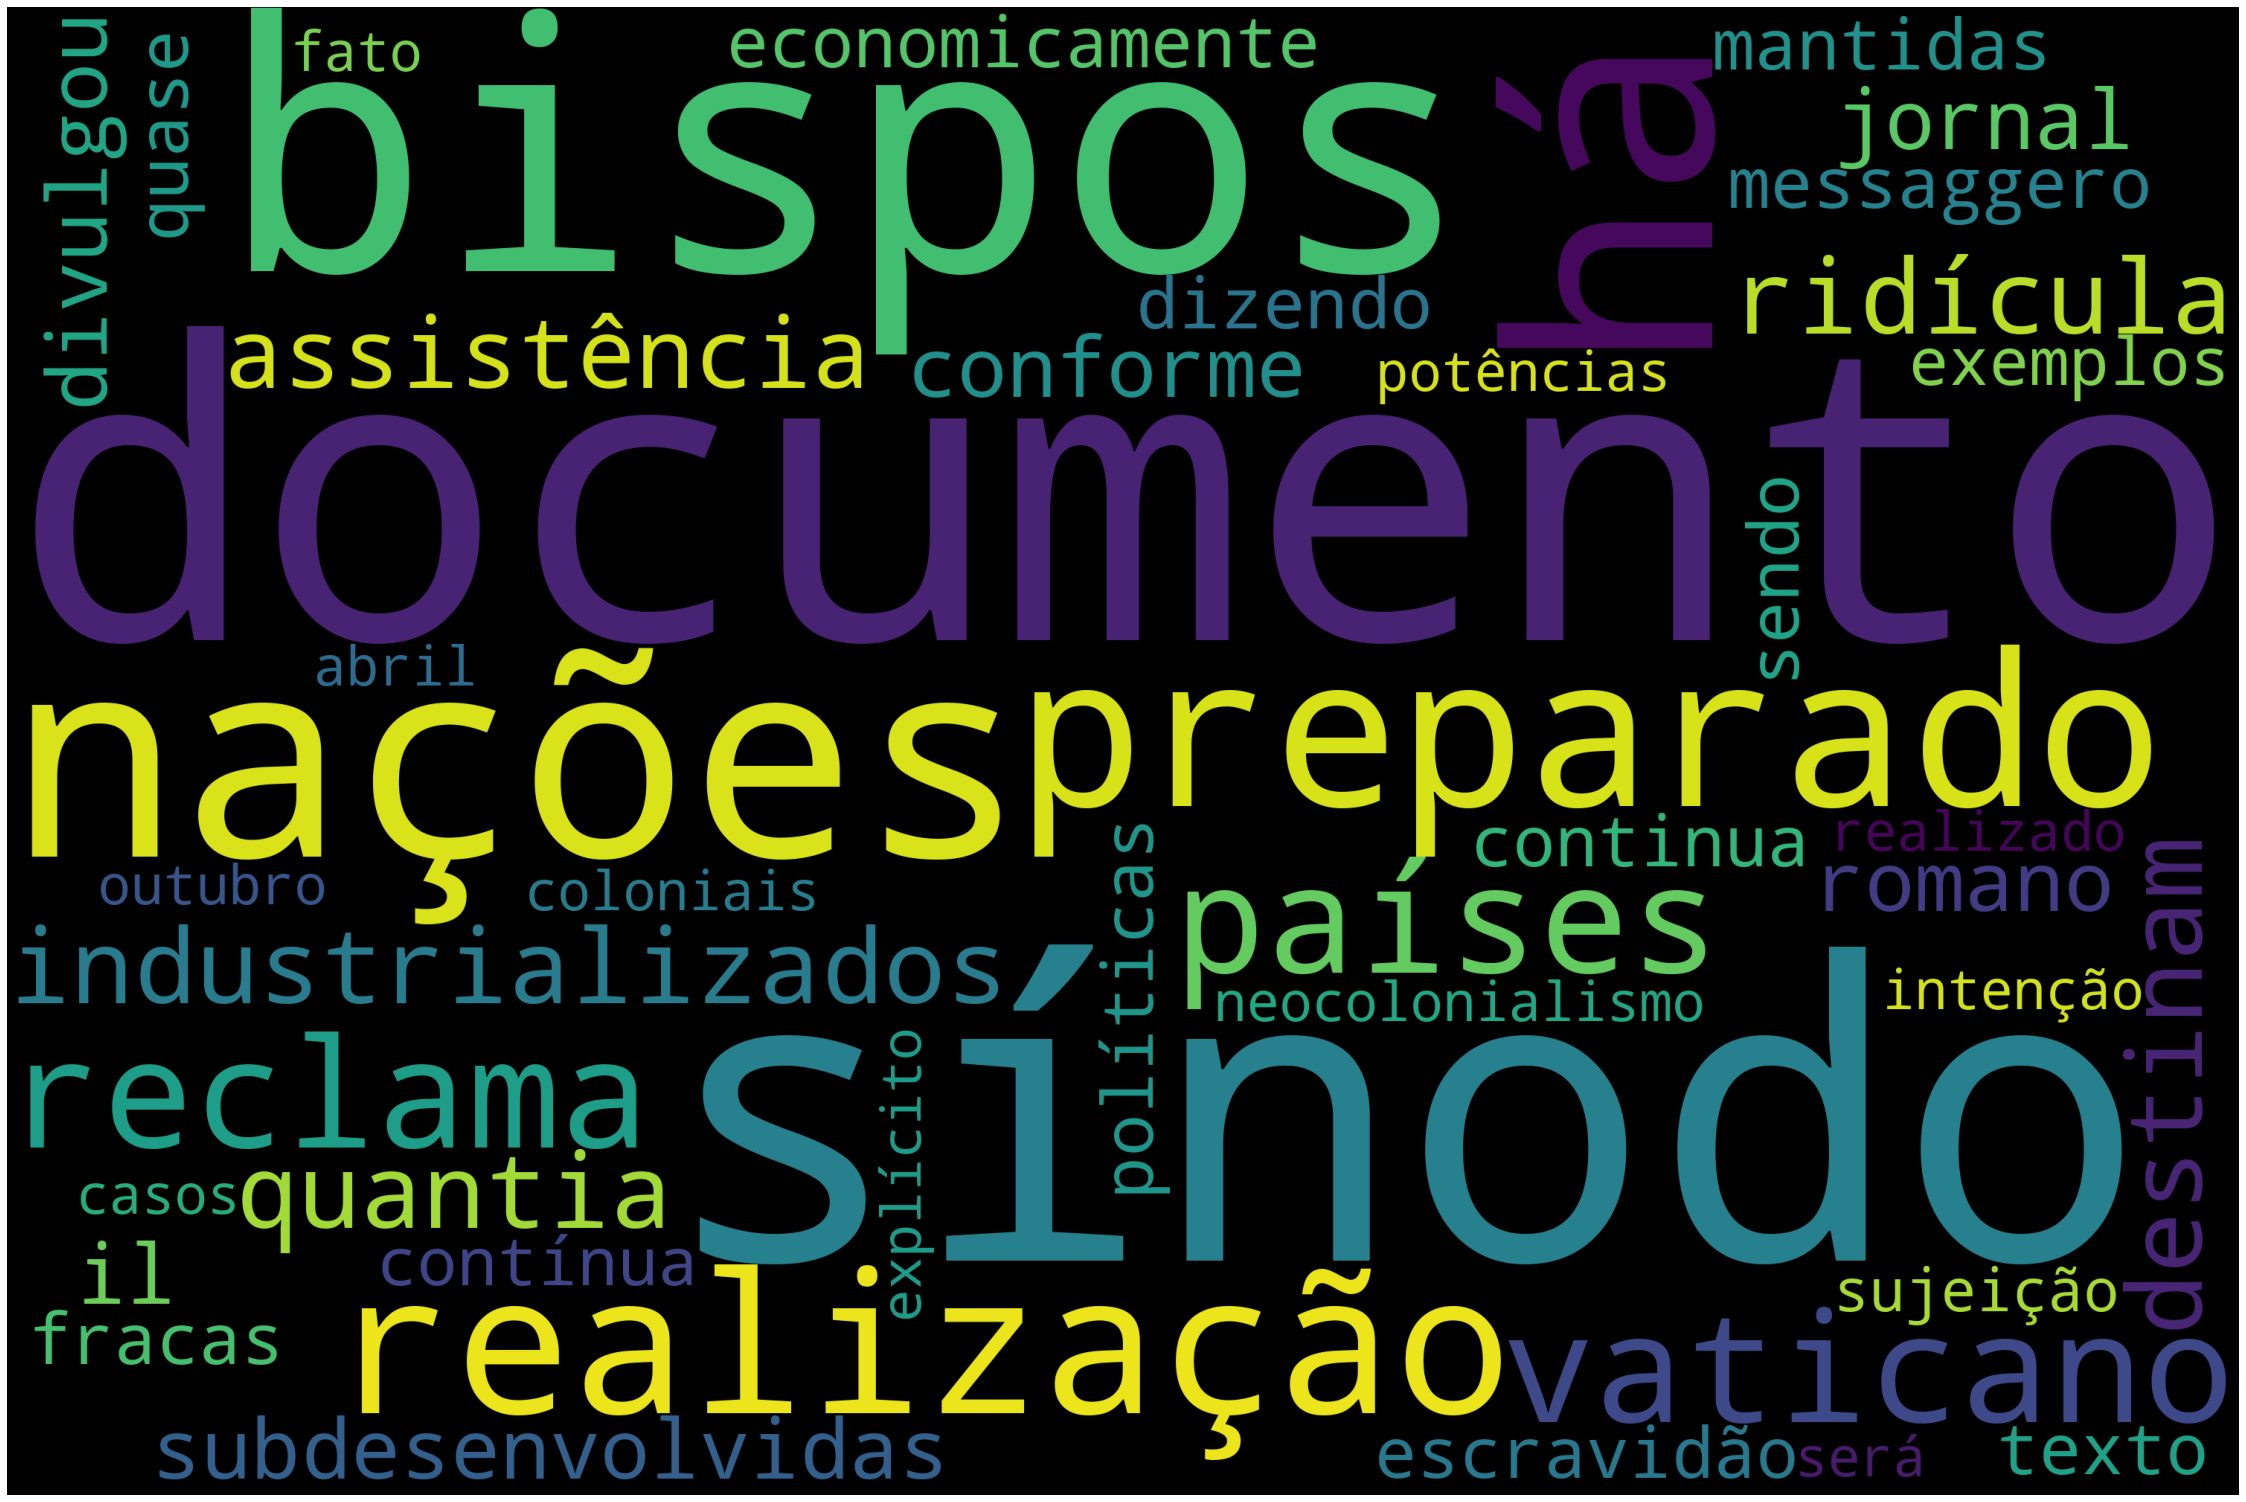

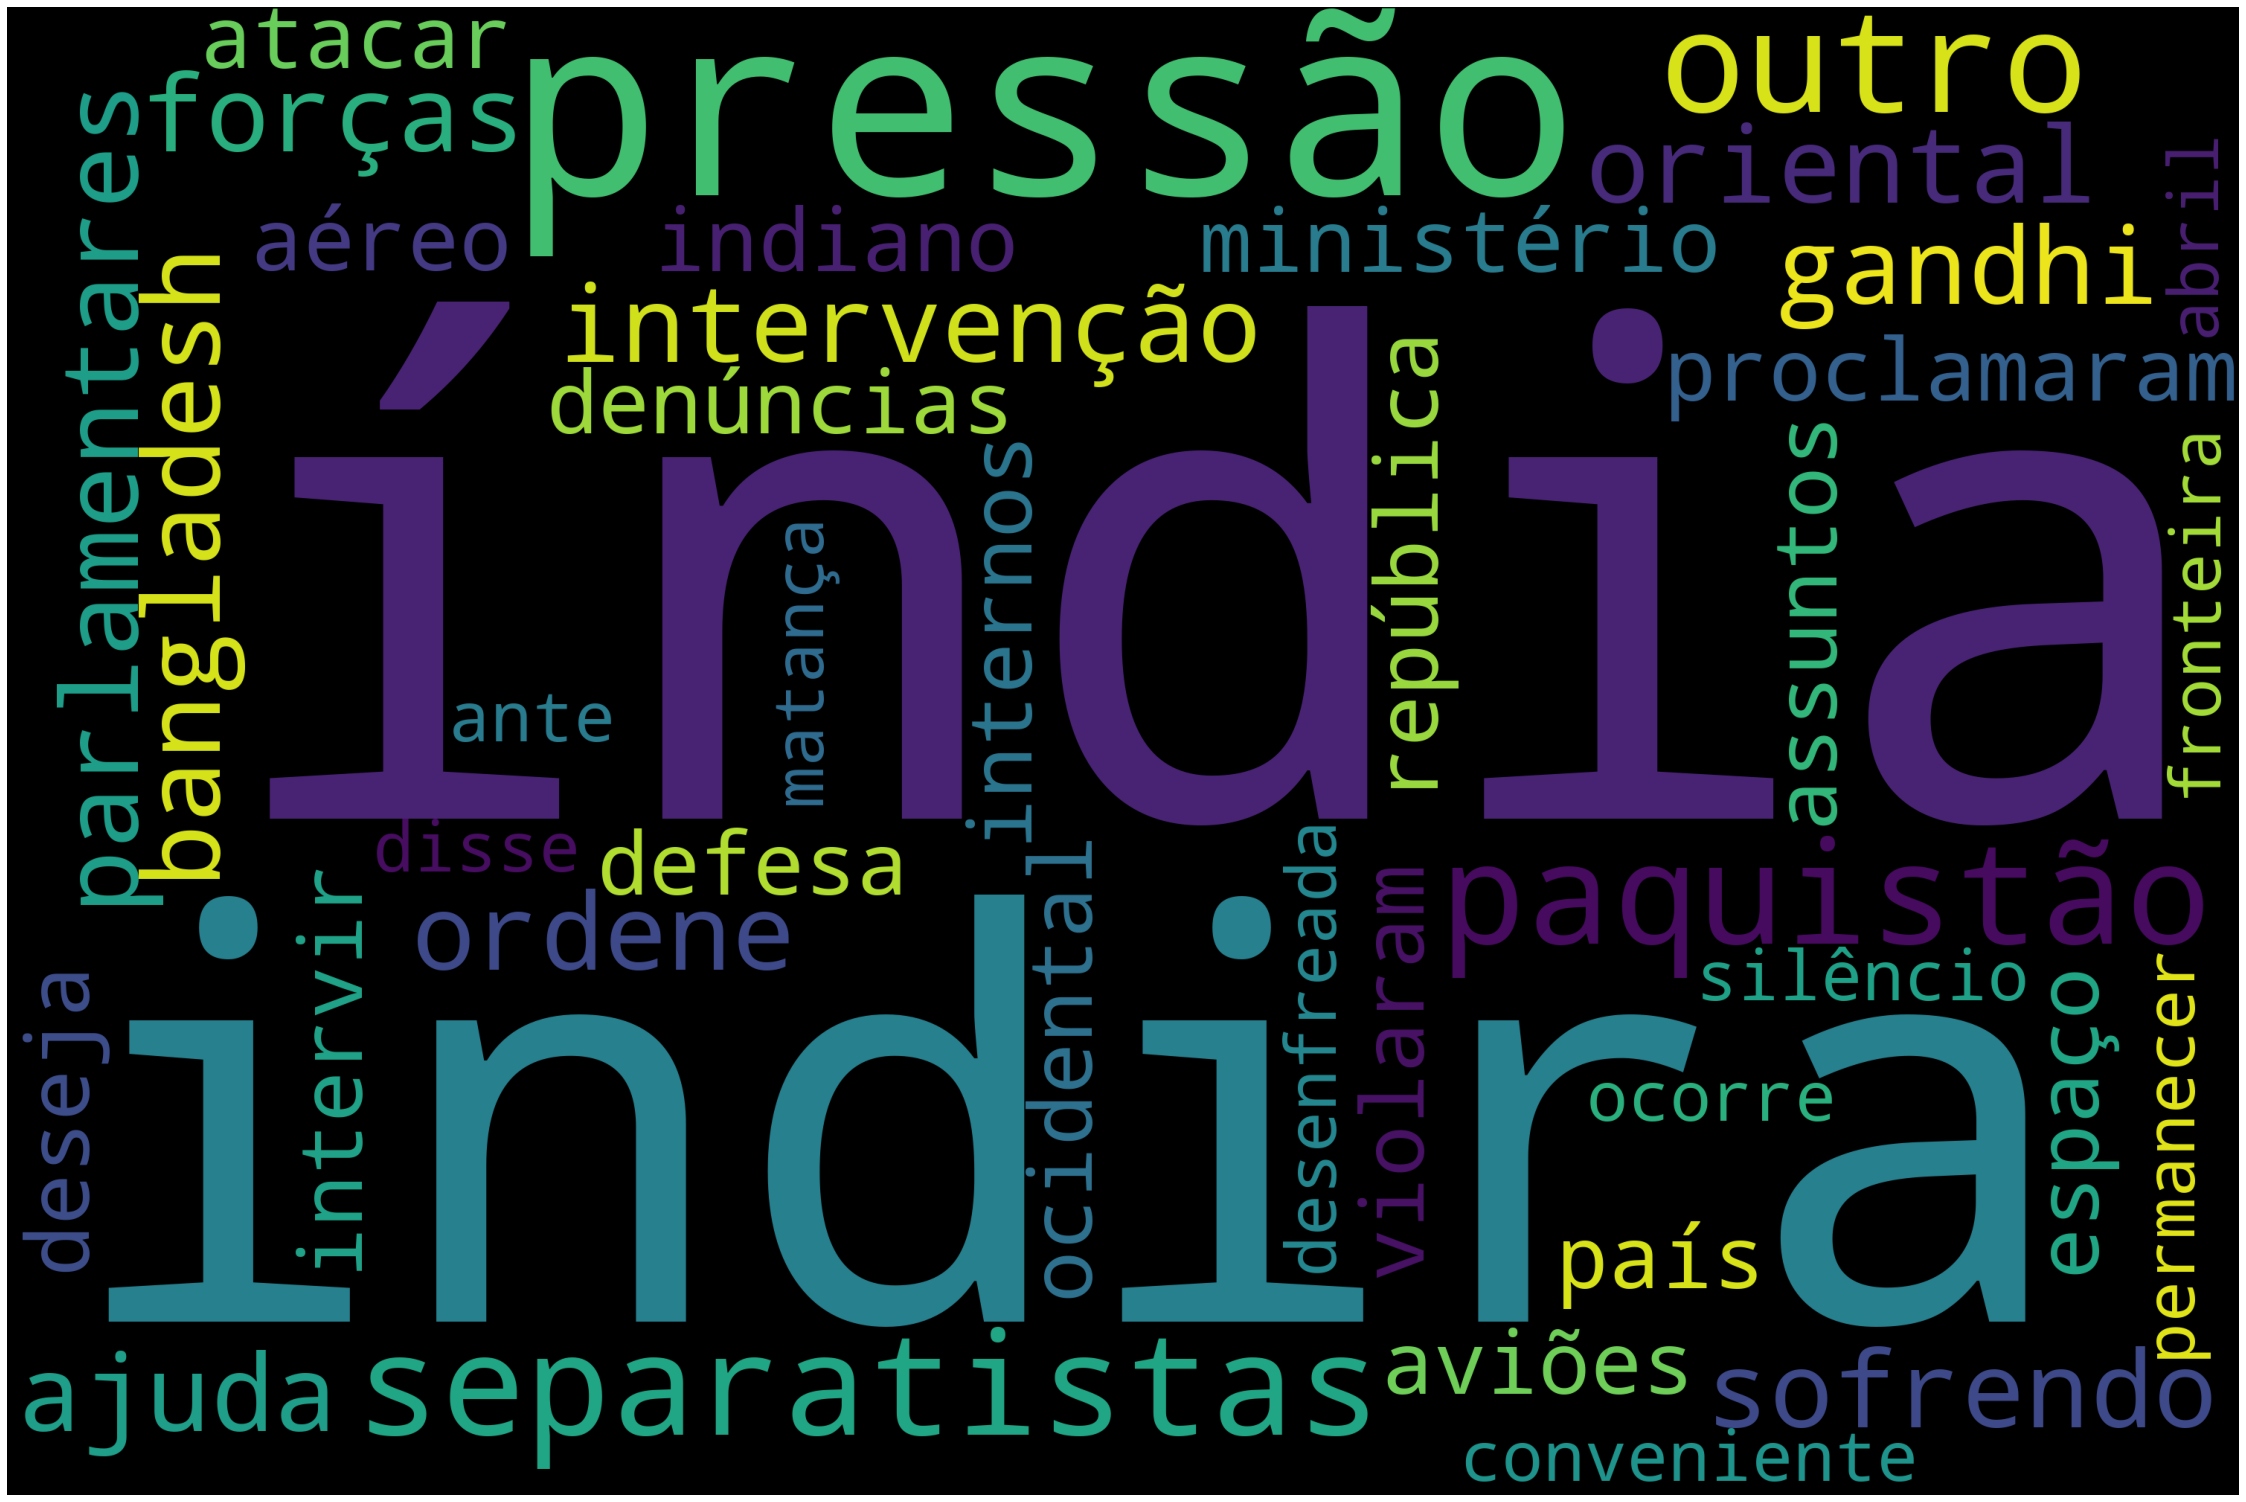

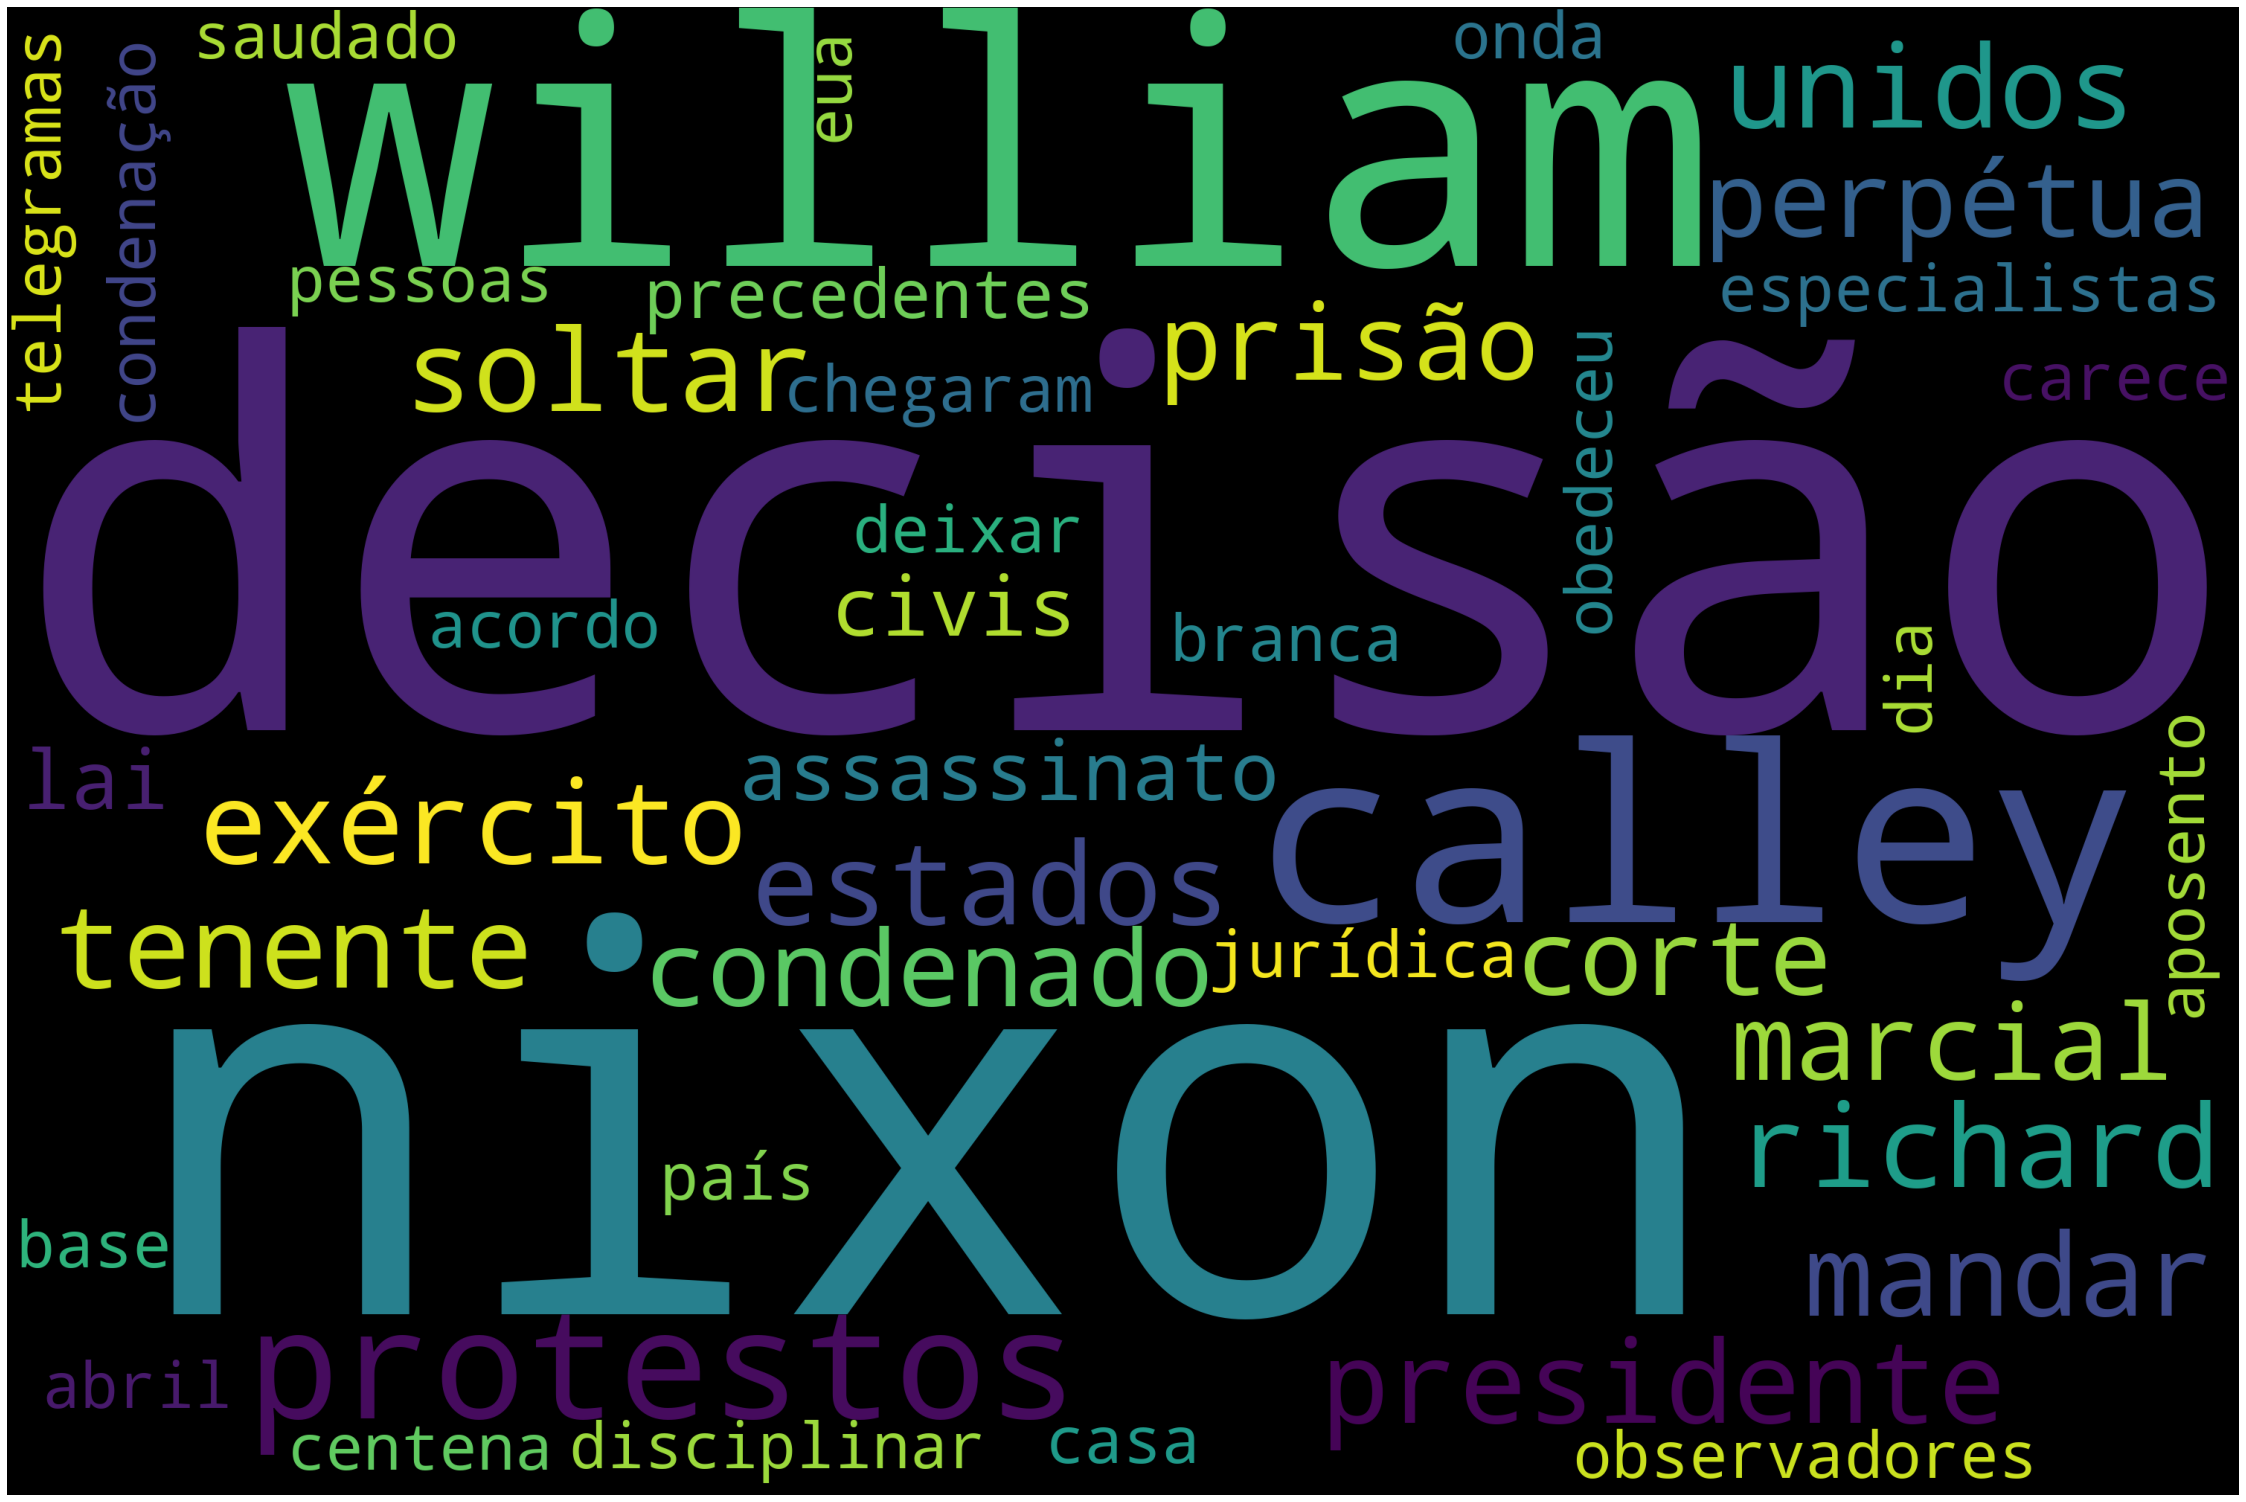

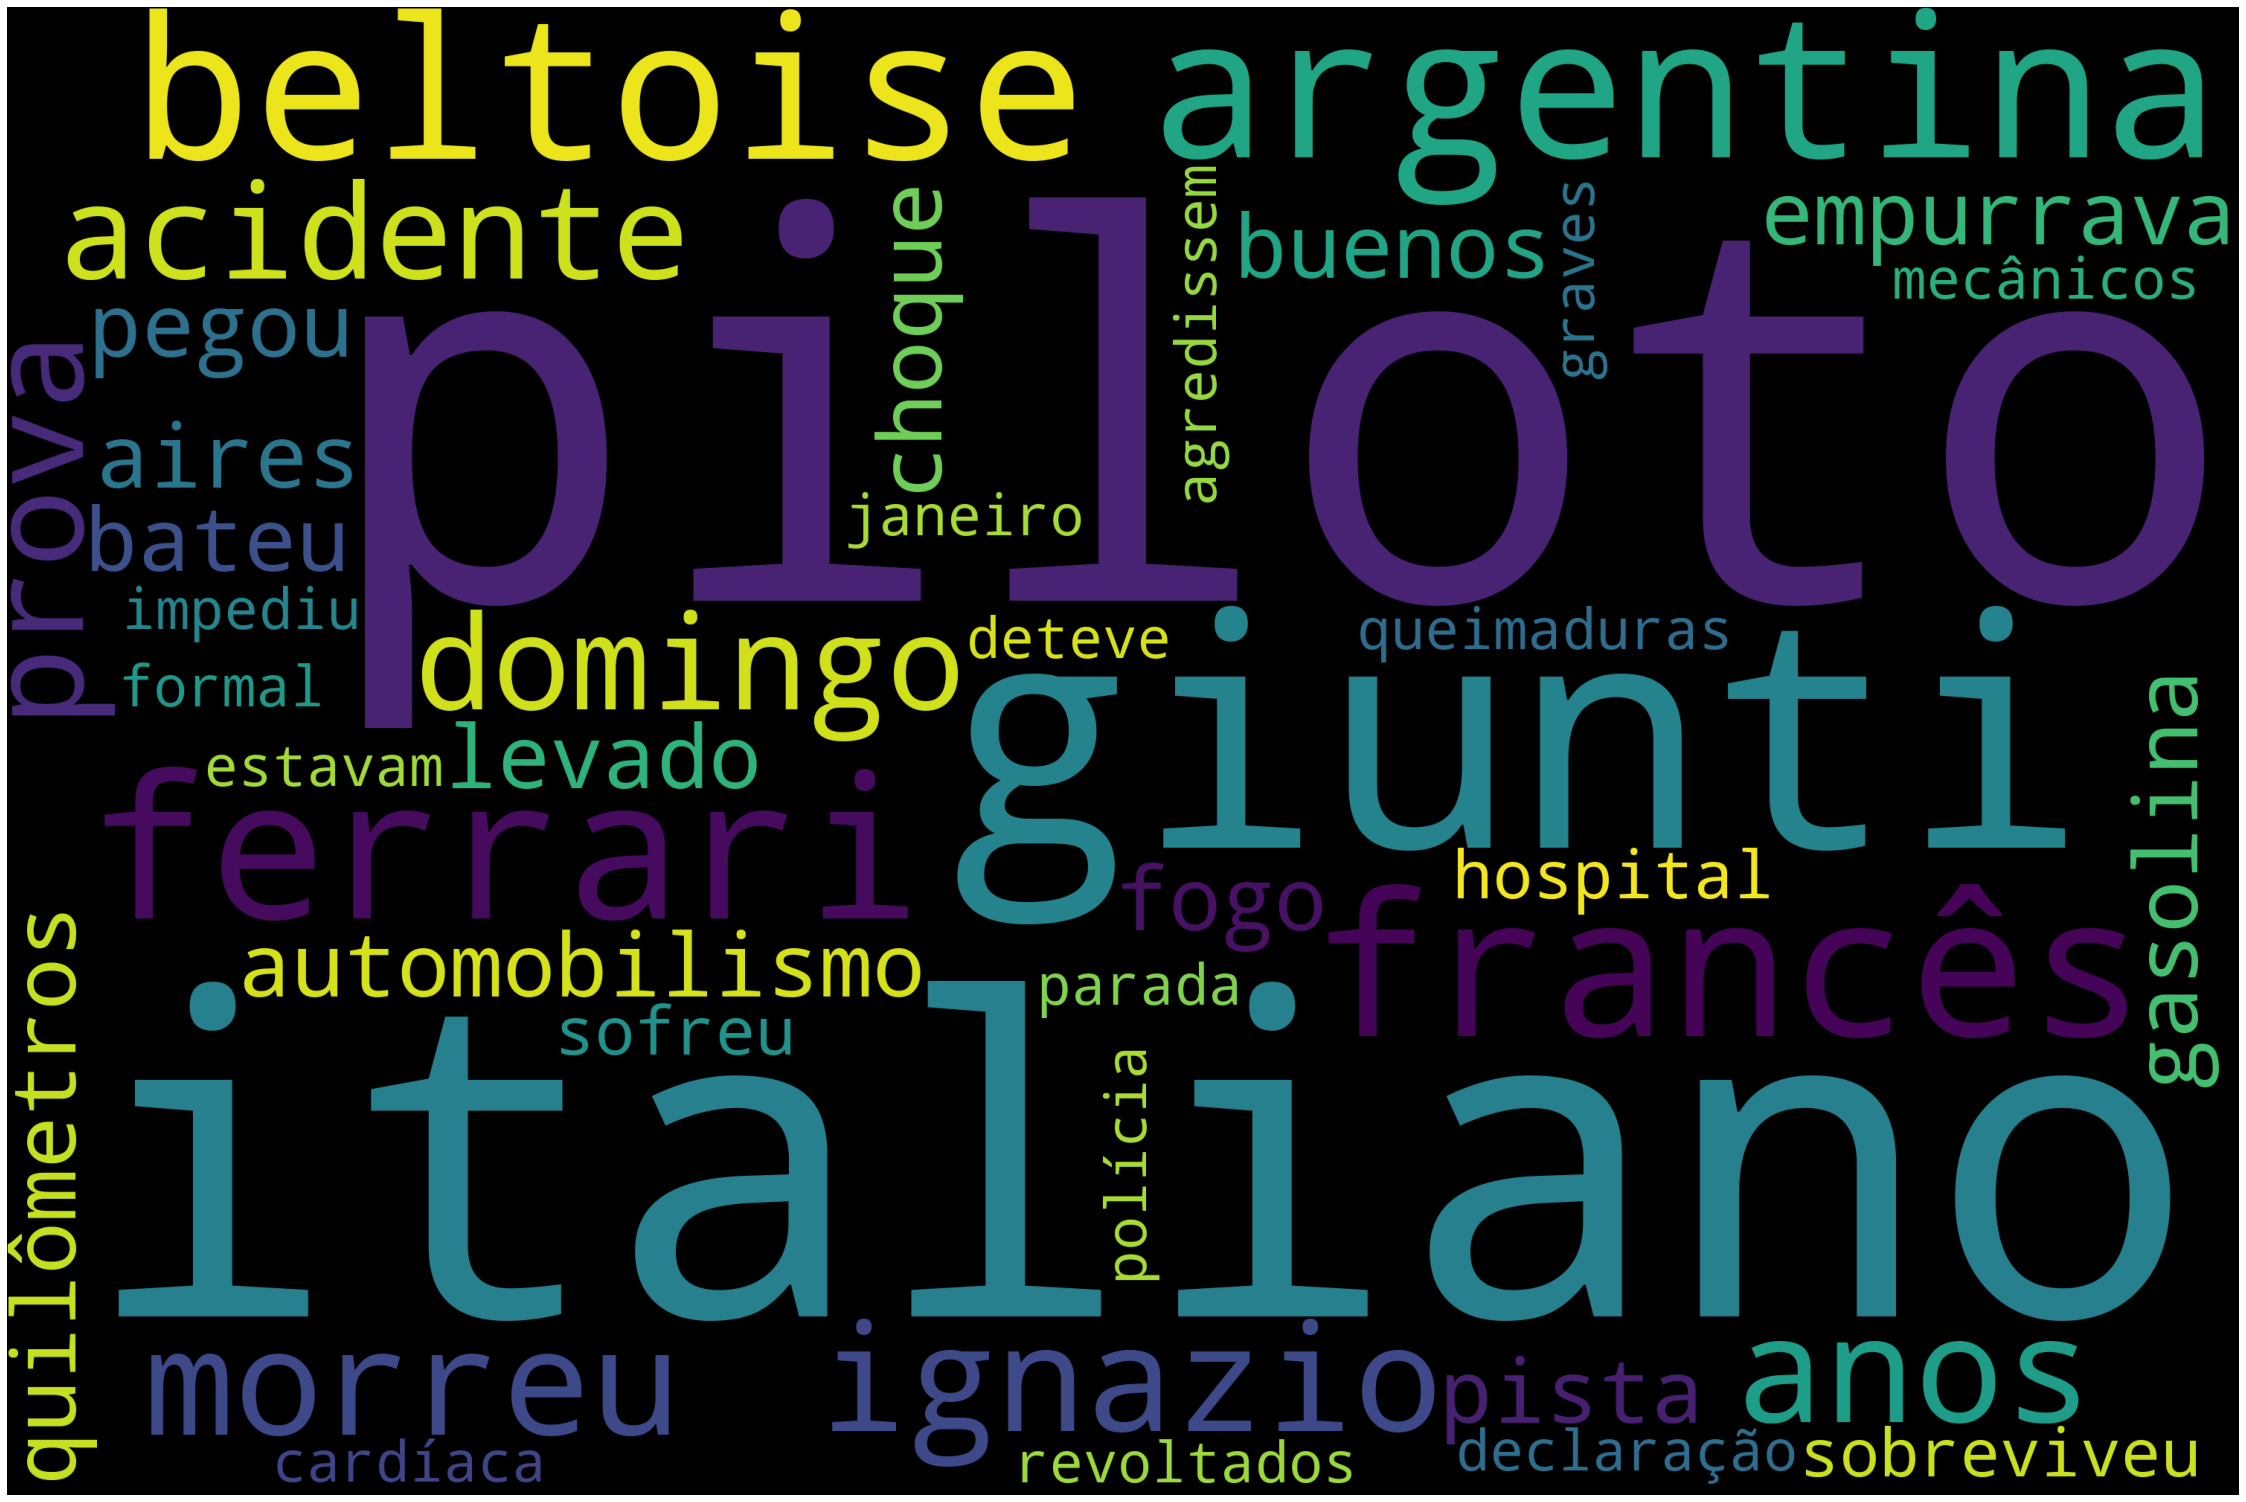

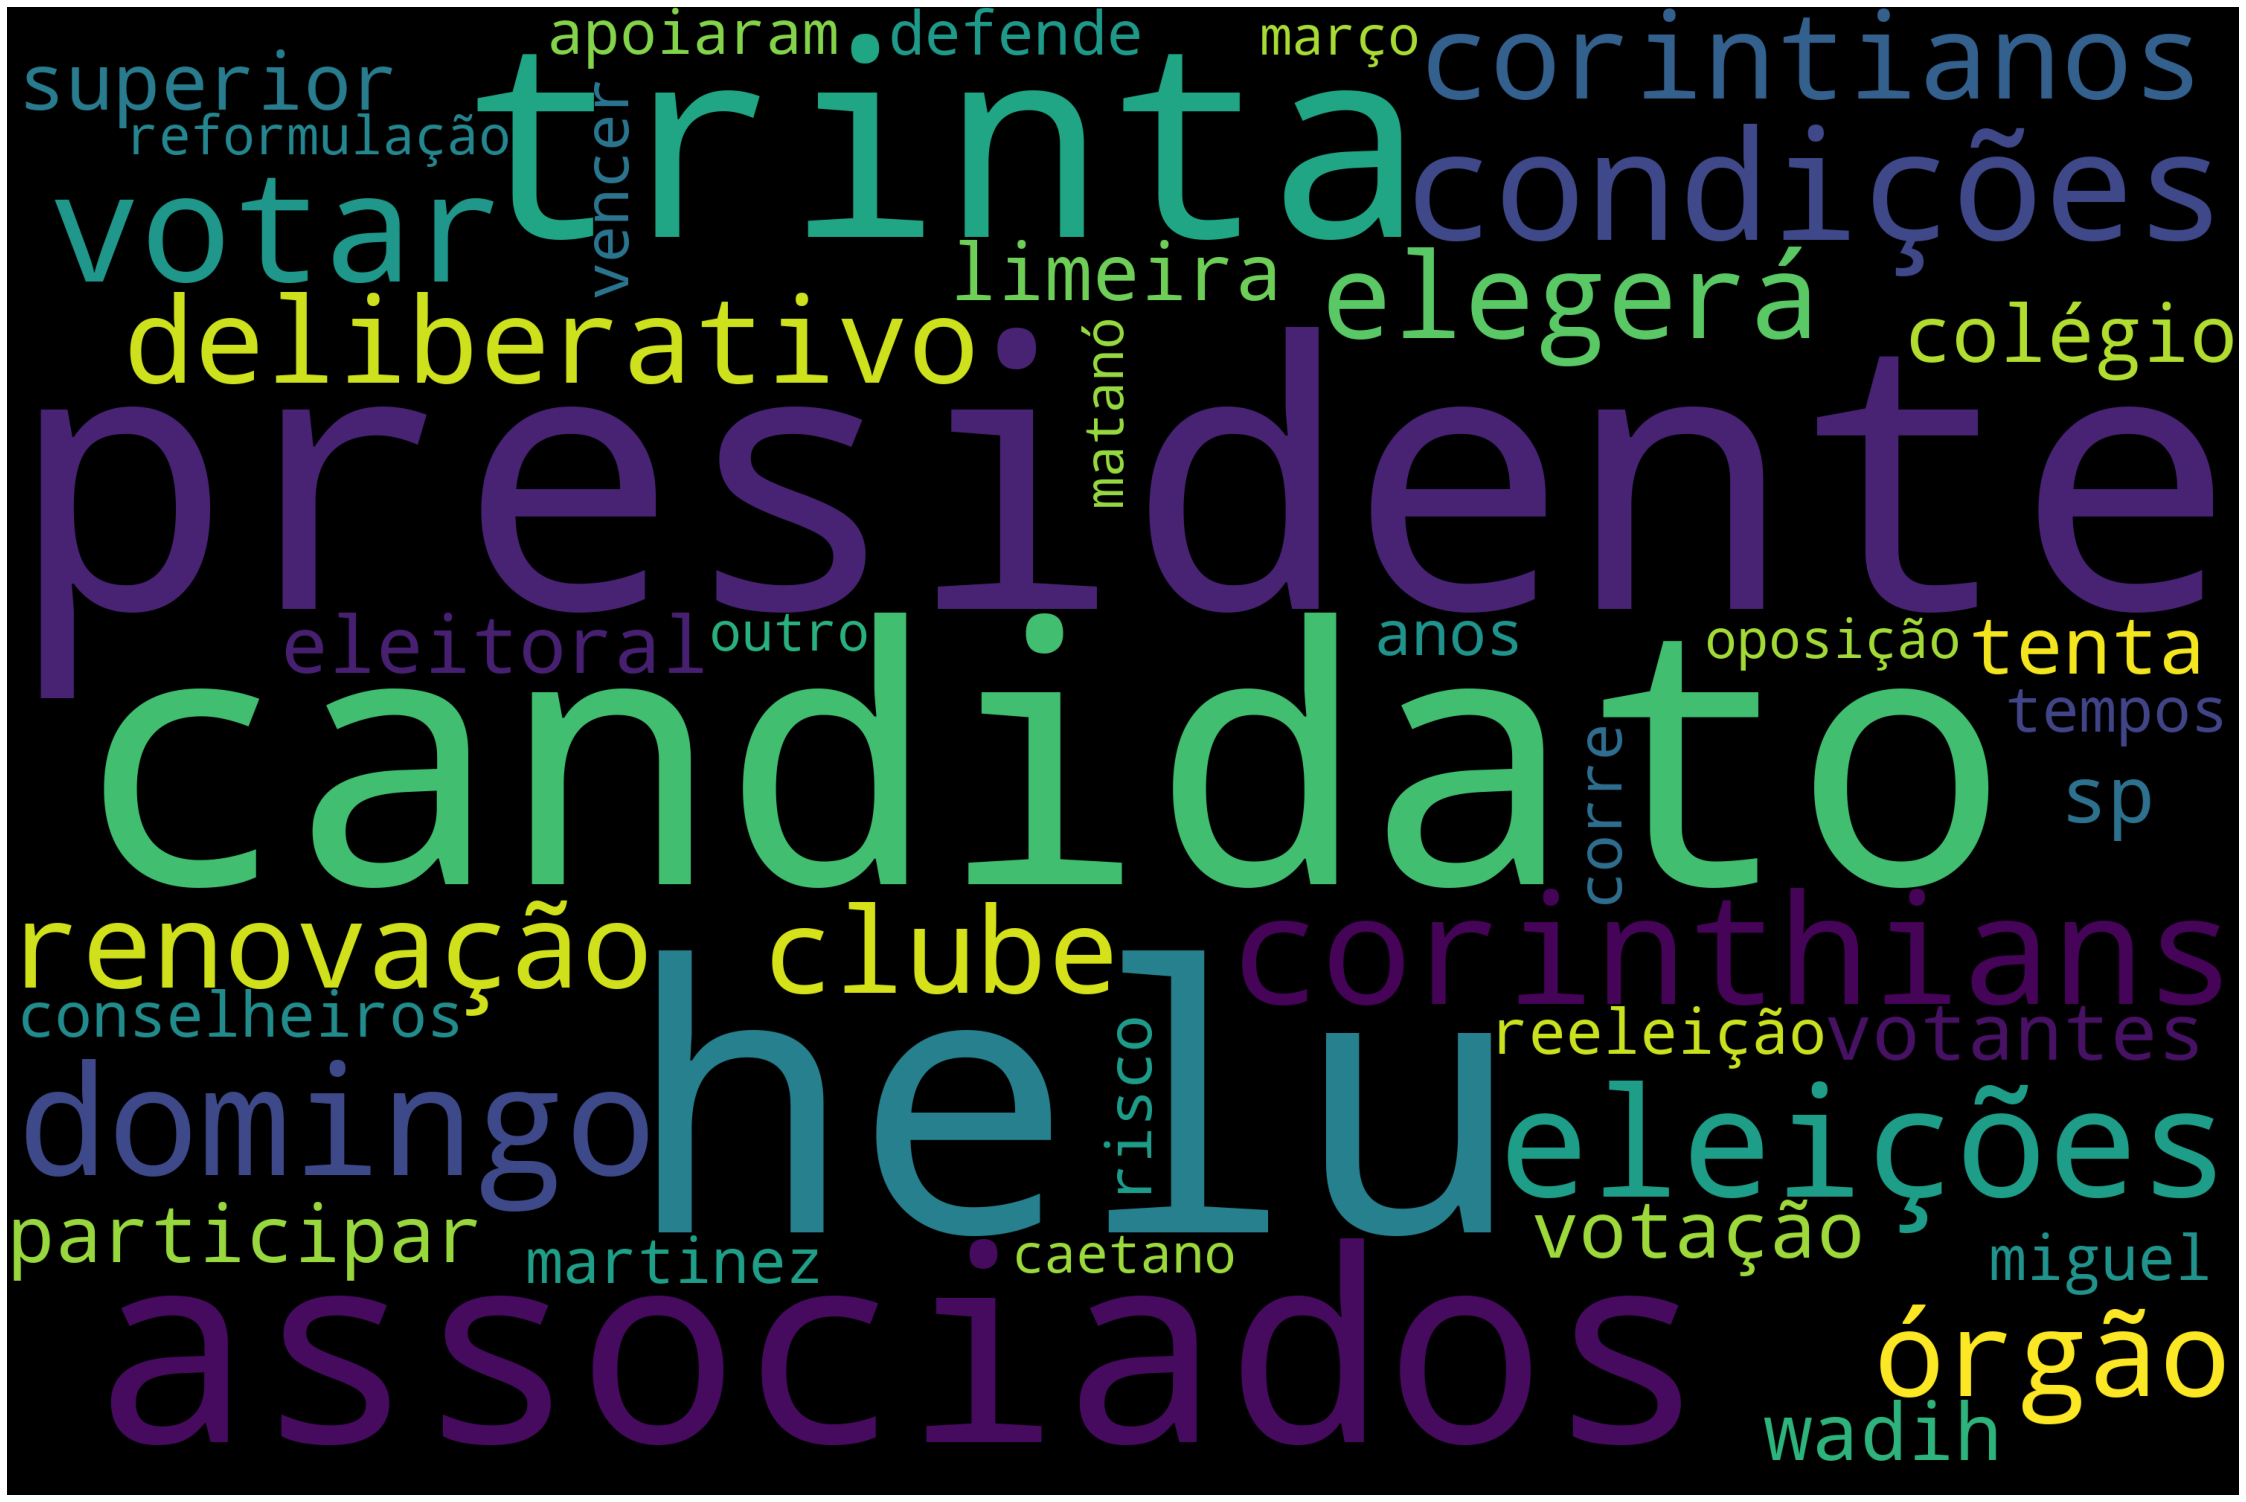

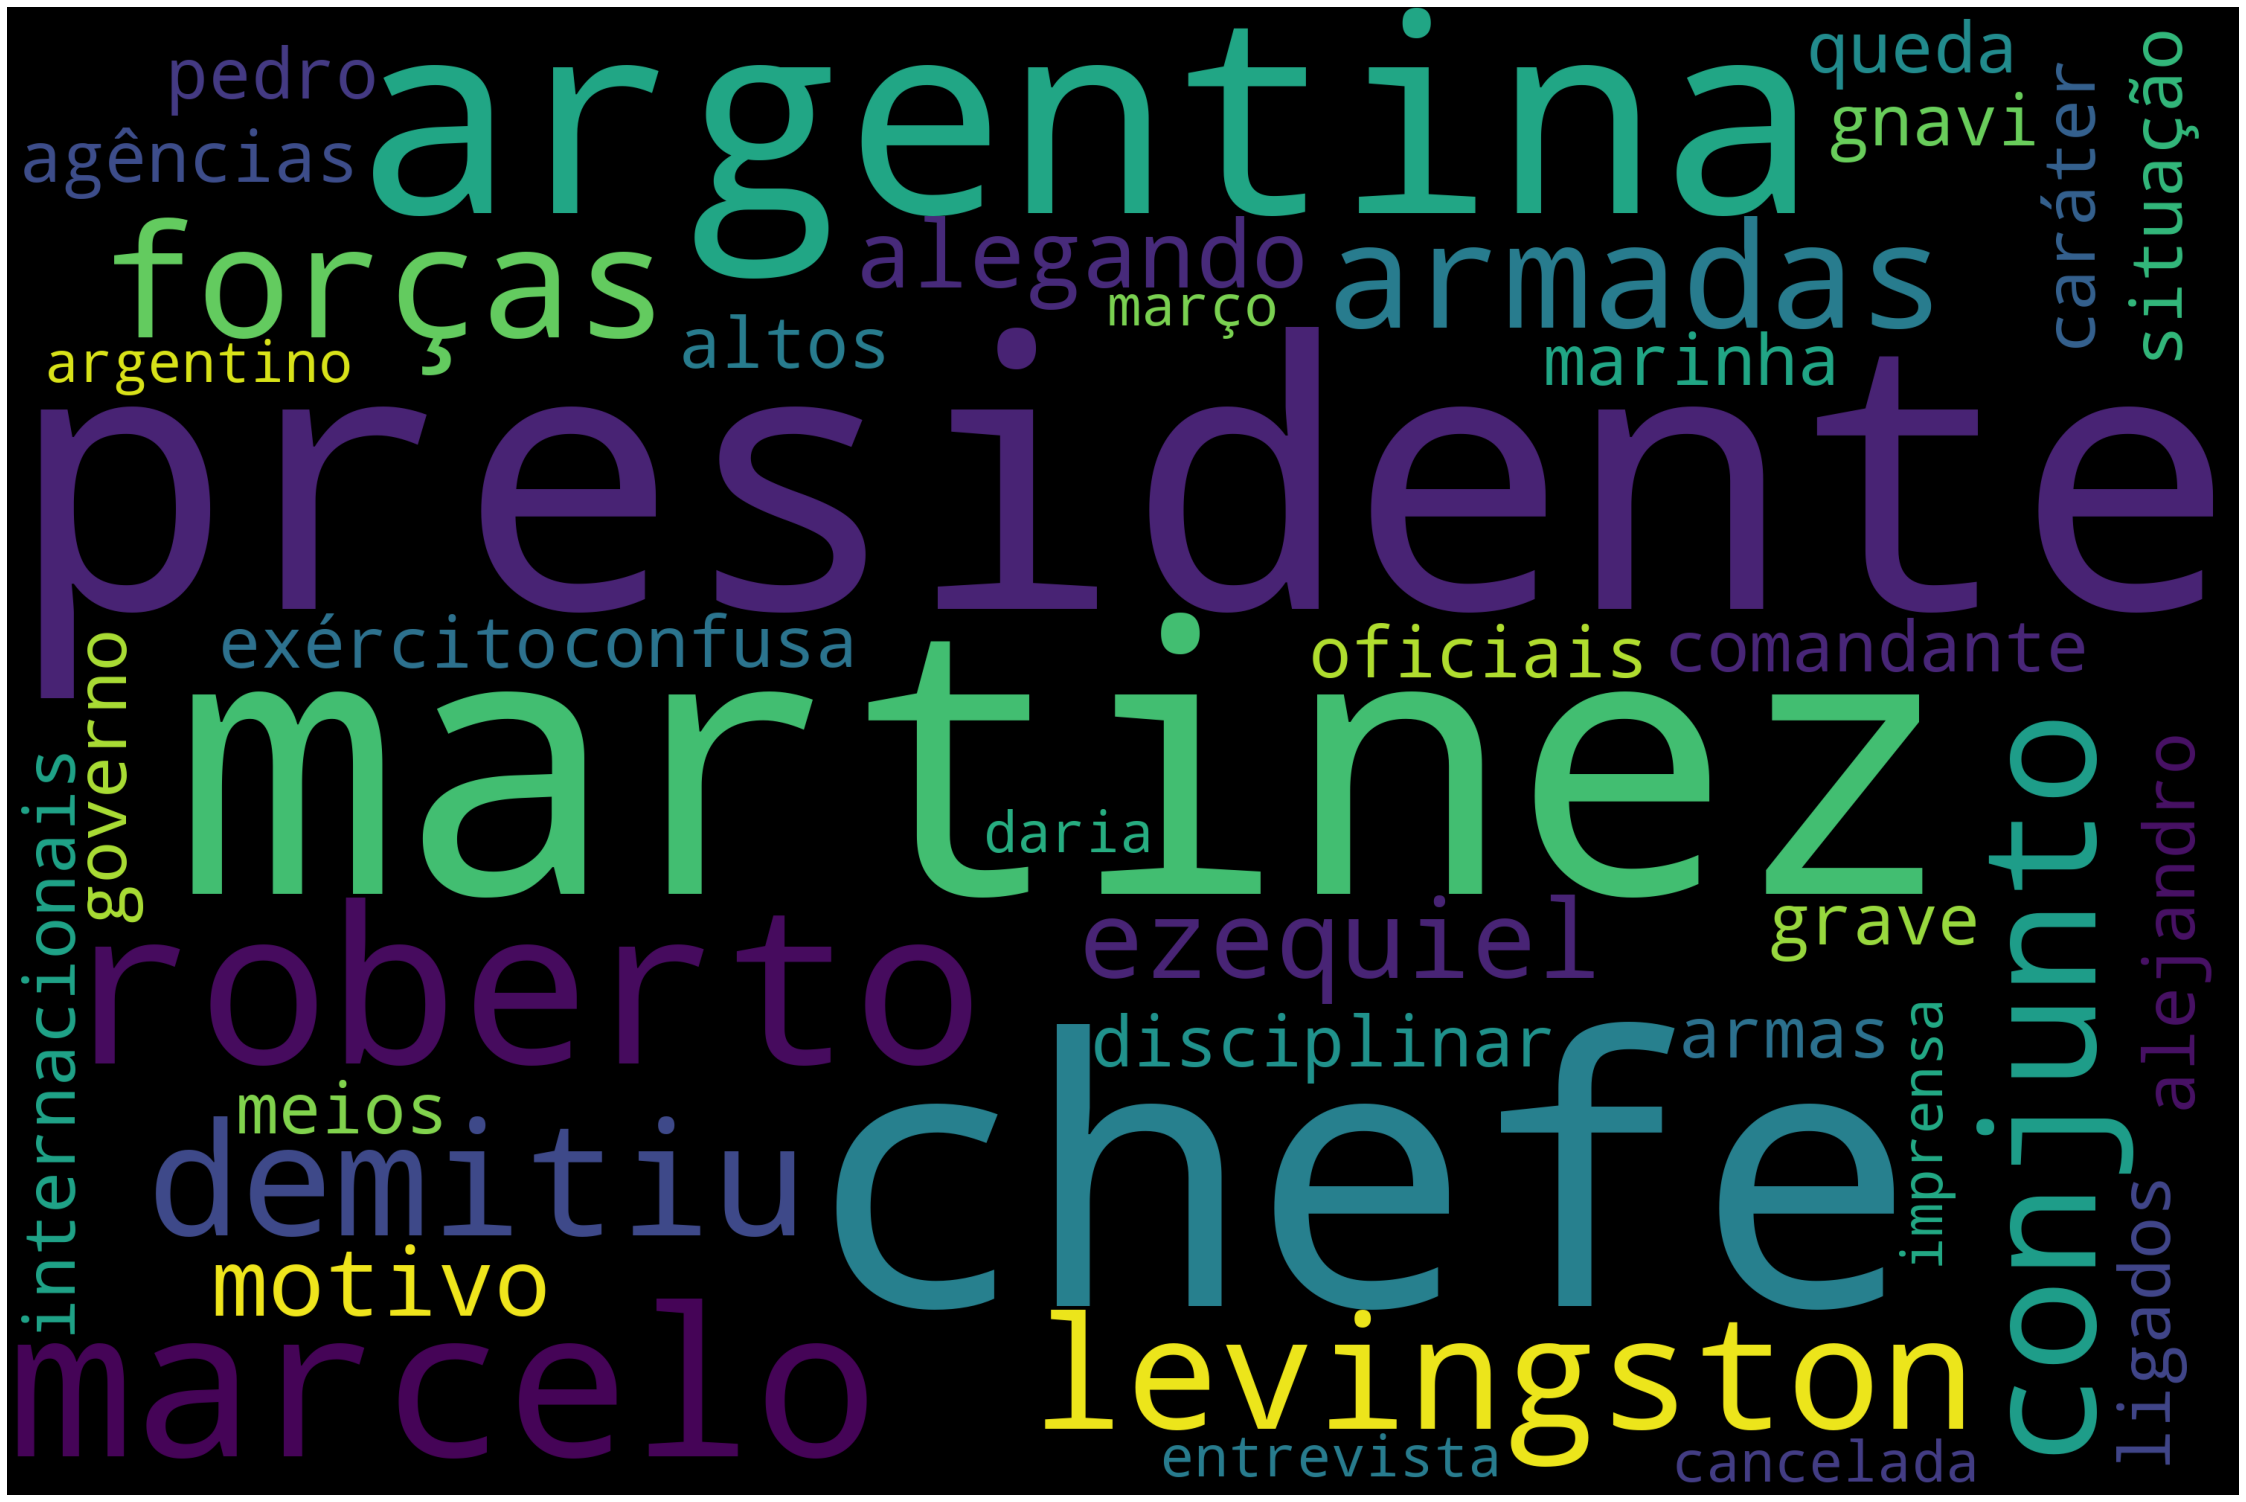

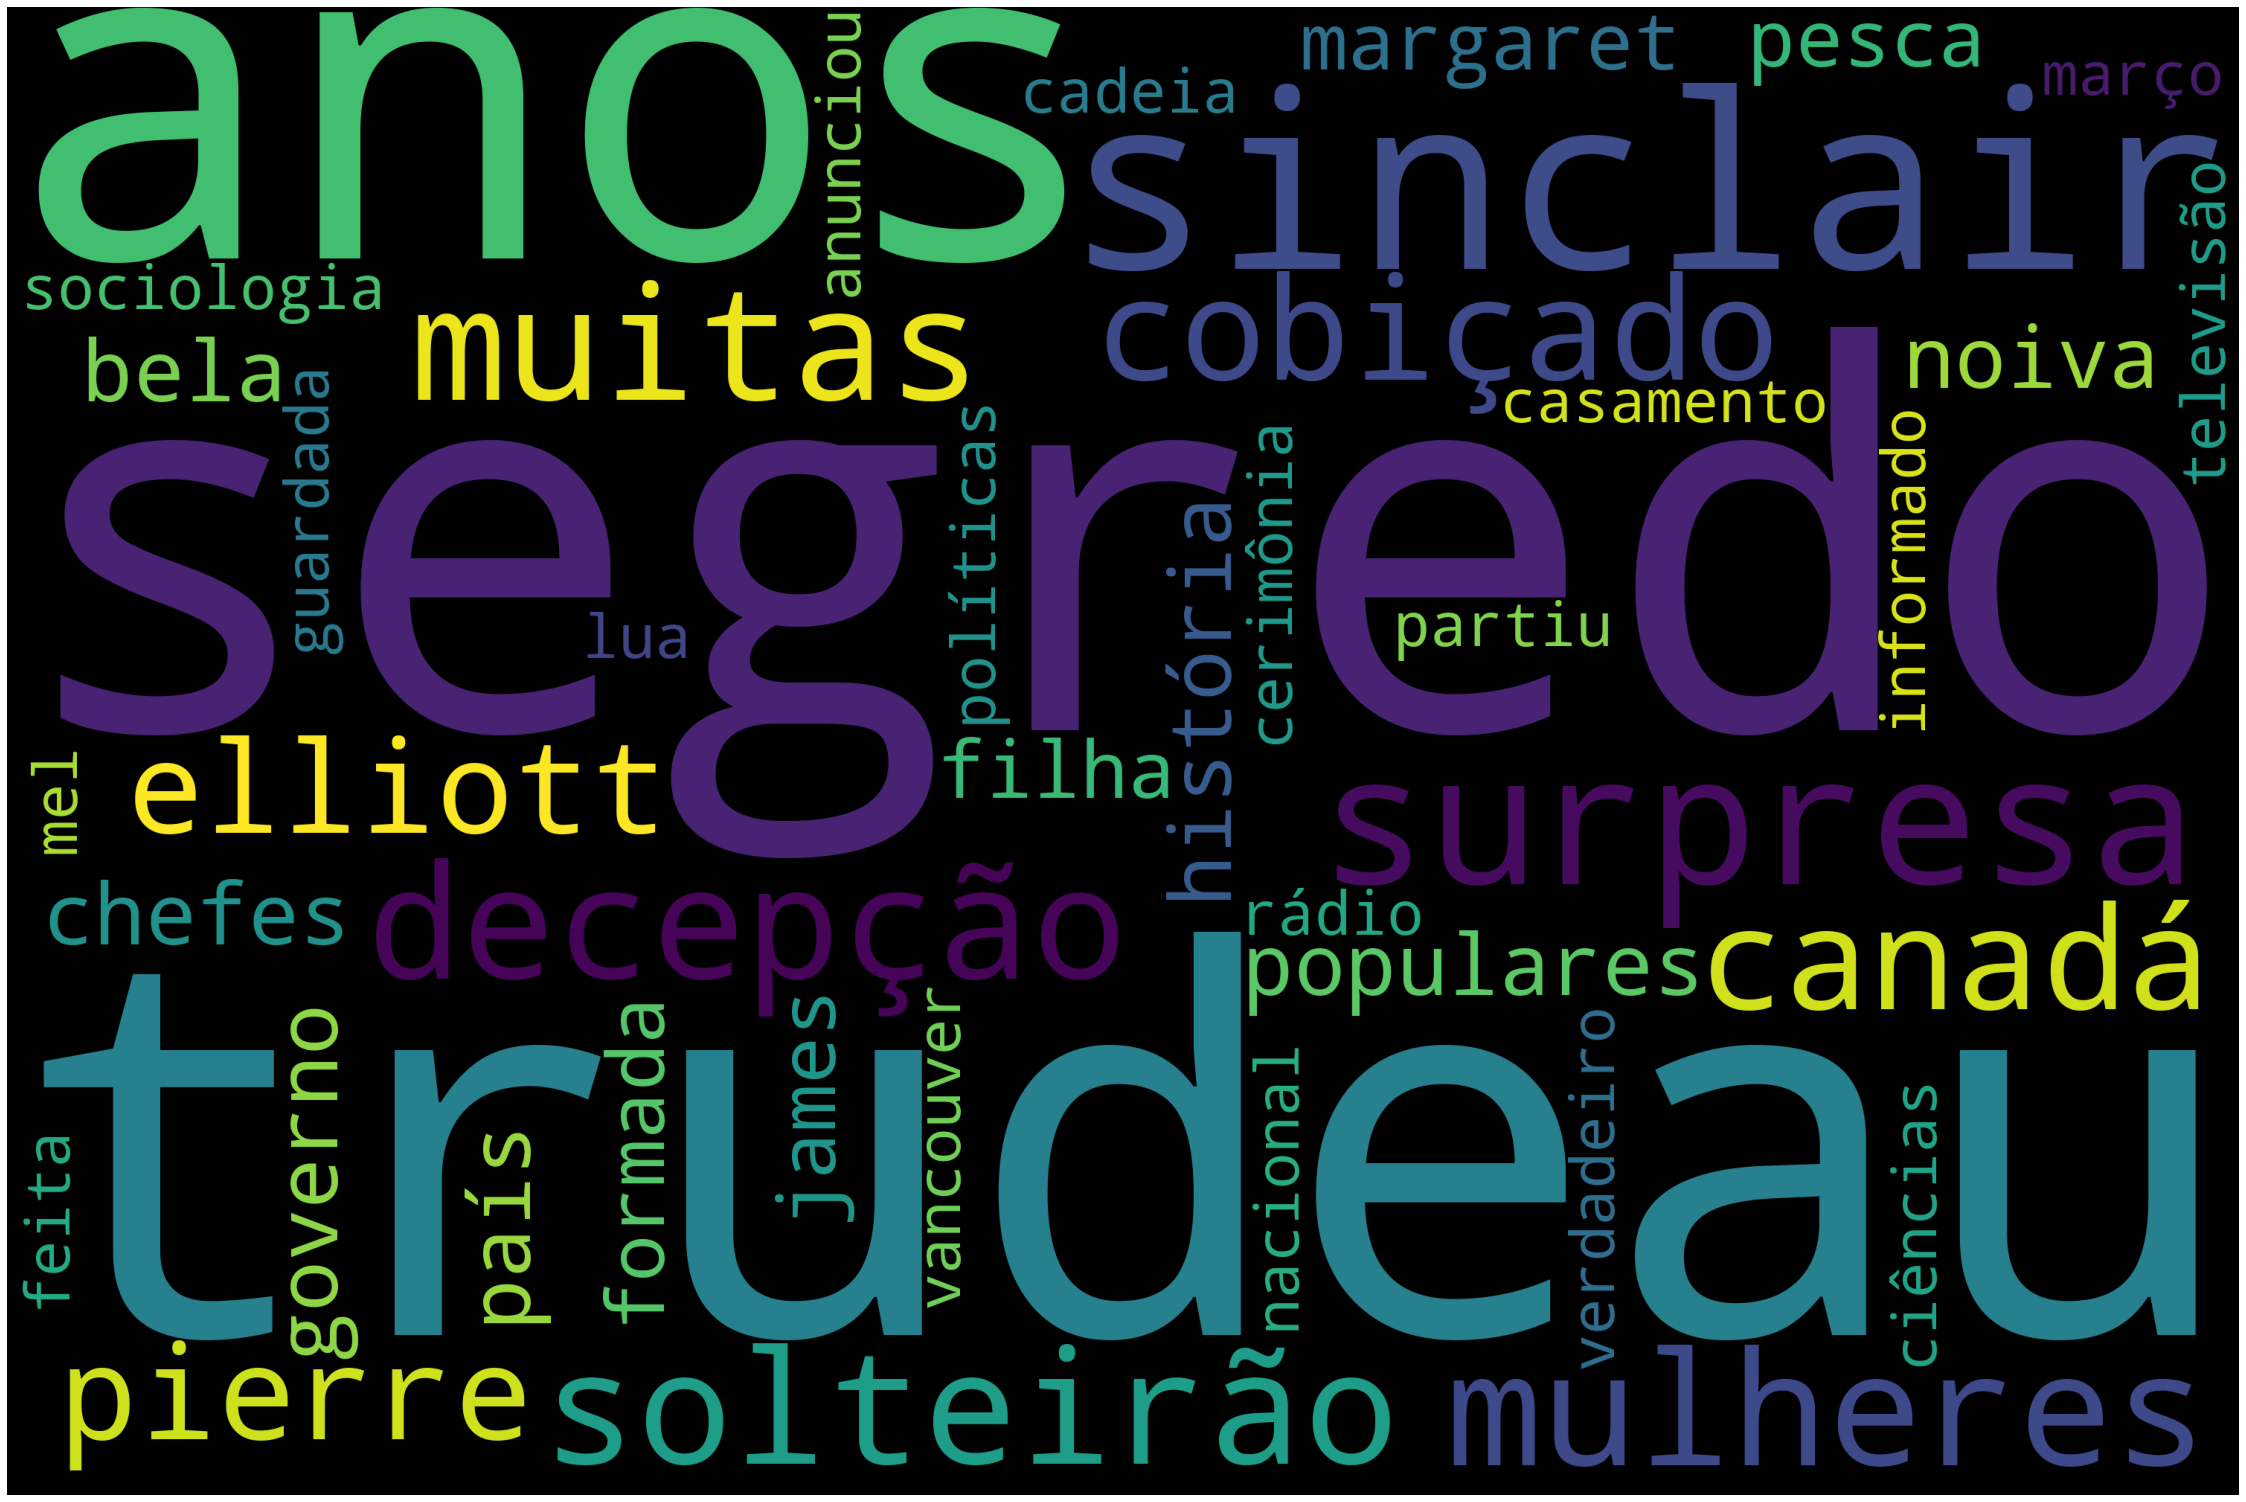

In [16]:
# todas as imagens são pré-processadas com a tokenização de stopwords e palavras alfabéticas
# de acordo com a sua função de frequência no texto, o retorno é o tamanho de cada palavra

for i in range(len(url)):
    mostrar_nuvem(cria_doc_tratado(textos_de_treino[i]))

### 5.2 Identificando verbos e entidades

In [17]:
# atribuindo os verbos e as entidades a uma lista, o qual pode ser puxada através de seu índice de 0 a 10

lista_de_verbos = []
lista_de_entidades = []

for i in range(len(url)):
    doc = cria_doc(textos_de_treino[i])
    verbo = [token.text for token in doc if token.pos_ == "VERB"]
    lista_de_verbos.append(verbo)
    entidades = doc.ents
    lista_de_entidades.append(entidades)

In [18]:
# puxando verbos do artigo 1
# basta mudar o índice para verificar os outros artigos

lista_de_verbos[0]

['assinou',
 'tornando',
 'destinava',
 'baixado',
 'comandada',
 'desapropriava',
 'formada',
 'visava',
 'explicou',
 'reservar']

In [19]:
# puxando entidades do artigo 1
# basta mudar o índice para verificar os outros artigos

lista_de_entidades[0]

(de São Paulo,
 José Carlos de Figueiredo Ferraz,
 Jardim Paulista,
 Paulo Maluf,
 Pamplona,
 São Carlos do Pinhal,
 Campinas,
 Ribeirão Preto,
 Prefeitura)

In [20]:
# mostrando entidades nomeadas

for i in range(len(url)):
    site = baixa_site(url[i])
    print("Artigo: " + cria_titulo(tratamento_texto(site)))
    doc = cria_doc(textos_de_treino[i])
    displacy.render(doc, style = 'ent', jupyter = True)
    print("")

Artigo: 1971: Prefeito revoga decreto que previa quarteirão verde no Jardim Paulista



Artigo: 1971: Governador diz conversar com prefeito de São Paulo diariamente



Artigo: 1971: Vicente Matheus é escolhido para ser diretor de futebol do Corinthians



Artigo: 1971: Vaticano afirma que países pobres recebem 'quantia ridícula' de ajuda



Artigo: 1971: Índia fala em matança e ameaça intervir para ajudar Bangladesh



Artigo: 1971: Nixon cede a clamor ao libertar condenado por massacre em My Lai



Artigo: 1971: Piloto italiano morre após Ferrari explodir em batida na Argentina



Artigo: 1971: A 'grande cidade' Corinthians vai às urnas; 30 mil podem votar



Artigo: 1971: Crise entre militares na cúpula do governo argentino se agrava



Artigo: 1971: Primeiro-ministro do Canadá se casa em segredo


### 6.0 Trabalhando com os Tweets
- Colocando todos os Tweets em um dataFrame, e pré-processando as informações
- Pré-processamento: removendo linhas duplicadas

In [21]:
# atribuindo todos os Tweets a um dataFrame

df = pd.read_csv('./Tweets_Mg.csv', encoding = 'utf-8')
df.head()

Unnamed: 0                      Created At  \
0           0  Sun Jan 08 01:22:05 +0000 2017   
1           1  Sun Jan 08 01:49:01 +0000 2017   
2           2  Sun Jan 08 01:01:46 +0000 2017   
3           3  Wed Jan 04 21:43:51 +0000 2017   
4           4  Mon Jan 09 15:08:21 +0000 2017   

                                                Text  \
0  ���⛪ @ Catedral de Santo Antônio - Governador ...   
1  � @ Governador Valadares, Minas Gerais https:/...   
2  �� @ Governador Valadares, Minas Gerais https:...   
3                        ��� https://t.co/BnDsO34qK0   
4  ��� PSOL vai questionar aumento de vereadores ...   

   Geo Coordinates.latitude  Geo Coordinates.longitude User Location  \
0                       NaN                        NaN        Brasil   
1                  -41.9333                     -18.85           NaN   
2                  -41.9333                     -18.85           NaN   
3                       NaN                        NaN           NaN   
4                       NaN                        NaN           NaN   

               Username User Screen Name  Retweet Count Classificacao  ...  \
0  Leonardo C Schneider    LeoCSchneider              0        Neutro  ...   
1               Wândell         klefnews              0        Neutro  ...   
2               Wândell         klefnews              0        Neutro  ...   
3         Ana estudando  estudandoconcur              0        Neutro  ...   
4                 Emily         Milly777              0      Negativo  ...   

  Unnamed: 15  Unnamed: 16  Unnamed: 17  Unnamed: 18  Unnamed: 19  \
0         NaN          NaN          NaN          NaN          NaN   
1         NaN          NaN          NaN          NaN          NaN   
2         NaN          NaN          NaN          NaN          NaN   
3         NaN          NaN          NaN          NaN          NaN   
4         NaN          NaN          NaN          NaN          NaN   

   Unnamed: 20  Unnamed: 21  Unnamed: 22  Unnamed: 23  Unnamed: 24  
0          NaN          NaN          NaN          NaN          NaN  
1          NaN          NaN          NaN          NaN          NaN  
2          NaN          NaN          NaN          NaN          NaN  
3          NaN          NaN          NaN          NaN          NaN  
4          NaN          NaN          NaN          NaN          NaN  

[5 rows x 26 columns]

In [22]:
# removendo todos as duplicatas

df.drop_duplicates(['Text'], inplace = True)

In [23]:
# atribuindo os valores dos Tweets e das Classificações (Positivo, Negativo e Neutro) para arrays NumPy

tweets = df['Text'].values
classificacao = df['Classificacao'].values

### 7.0 Trabalhando com as classificações
- Para essa avaliação, resolvi escolher os modelos MultinomialNB e RandomForestClassifier
- A escolha dos mesmos foi fundamentada no artigo https://www.kaggle.com/leandrodoze/sentiment-analysis-in-portuguese

In [24]:
# sentimentos a serem analisados - TAGS

sentimentos = ["Positivo", "Negativo", "Neutro"]

### 7.1 Modelo MultinomialNB
- Confira a documentação em: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [25]:
# primeiro exemplo: MultinomialNB

# a vetorização dos dados será baseada em ngram's - tal como divide frases em 2 palavras, capturando o seu sentimento
# detalhes sobre o ngram: https://scikit-learn.org/stable/modules/feature_extraction.html


vetor = CountVectorizer(ngram_range = (1, 2))
frequenciaTweets = vetor.fit_transform(tweets)

modeloMultinomial = MultinomialNB()
modeloMultinomial.fit(frequenciaTweets, classificacao)

MultinomialNB()

In [26]:
# resultado de previsão utilizando o MultinomialNB

resultados = cross_val_predict(modeloMultinomial, frequenciaTweets, classificacao, cv = 10)
resultados

array(['Neutro', 'Neutro', 'Neutro', ..., 'Positivo', 'Positivo',
       'Positivo'], dtype='<U8')

In [27]:
print("Acurácia do modelo MultinomialNB é de: {}%".format(round(metrics.accuracy_score(classificacao, resultados) * 100, 2)))

Acurácia do modelo MultinomialNB é de: 87.03%


In [28]:
print("Informações de precisão para cada classificação: ")
print(metrics.classification_report(classificacao, resultados, sentimentos))

Informações de precisão para cada classificação: 
              precision    recall  f1-score   support

    Positivo       0.97      0.88      0.92      2840
    Negativo       0.70      0.92      0.79       951
      Neutro       0.85      0.84      0.84      1974

    accuracy                           0.87      5765
   macro avg       0.84      0.88      0.85      5765
weighted avg       0.88      0.87      0.87      5765



/home/joao/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['Positivo', 'Negativo', 'Neutro'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


### 7.2 Modelo RandomForestClassifier
- Confira a documentação em: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [29]:
# segundo exemplo: RandomForestClassifier

# a vetorização dos dados será baseada em estimadores - baseando-se em uma série de classificação por várias sub-amostras
# RandomForestClassifier foi criada no intuito de ser melhor nas previsões e acurárias dos demais classificadores
# detalhes em: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

vetor = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 10000)
treinandoOsTweets = vetor.fit_transform(tweets)

modeloForest = RandomForestClassifier(n_estimators = 10)

In [30]:
# capturando todos os sentimentos dos tweets

classe_sentimentos = df["Classificacao"].values
classe_sentimentos

array(['Neutro', 'Neutro', 'Neutro', ..., 'Positivo', 'Positivo',
       'Positivo'], dtype=object)

In [31]:
# treinando o modelo RandomForestClassifier com os sentimentos dos tweets e com os tweets

modeloForest = modeloForest.fit(treinandoOsTweets, classe_sentimentos)
modeloForest

RandomForestClassifier(n_estimators=10)

In [32]:
# transformando os textos dos artigos em textos classificados 

treinandoOsTextos = vetor.transform(textos_de_treino)
treinandoOsTextos

<10x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 406 stored elements in Compressed Sparse Row format>

In [33]:
# capturando os resultados dos artigos treinados, juntamente com seus sentimentos

resultados = modeloForest.predict(treinandoOsTextos)
resultados

array(['Neutro', 'Negativo', 'Positivo', 'Neutro', 'Neutro', 'Neutro',
       'Neutro', 'Neutro', 'Negativo', 'Neutro'], dtype=object)

In [34]:
pontuacao = cross_val_score(modeloForest, treinandoOsTextos, resultados, cv = 5)
print("Acurácia do modelo RandomForestClassifier é de: {}%".format(pontuacao.mean() * 100))


Acurácia do modelo RandomForestClassifier é de: 70.0%


/home/joao/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [35]:
# atribuindo o título de cada artigo, juntamente com o resultado final do sentimento

tabelaResultado = pd.DataFrame(data = {"titulo":titulos_dos_textos, "sentimento":resultados})
tabelaResultado

titulo sentimento
0  1971: Prefeito revoga decreto que previa quart...     Neutro
1  1971: Governador diz conversar com prefeito de...   Negativo
2  1971: Vicente Matheus é escolhido para ser dir...   Positivo
3  1971: Vaticano afirma que países pobres recebe...     Neutro
4  1971: Índia fala em matança e ameaça intervir ...     Neutro
5  1971: Nixon cede a clamor ao libertar condenad...     Neutro
6  1971: Piloto italiano morre após Ferrari explo...     Neutro
7  1971: A 'grande cidade' Corinthians vai às urn...     Neutro
8  1971: Crise entre militares na cúpula do gover...   Negativo
9  1971: Primeiro-ministro do Canadá se casa em s...     Neutro

### 8.0 Inserindo no banco de dados os títulos e os sentimentos
- Inserindo todas as análises sentimentais dos artigos, agregando um título a um texto do artigo e sua correspondente análise sentimental

In [36]:
# criando uma coleção, para inserir as informações no banco
# dados da tabelaResultado
# todos os dados serão divididos em títulos e sentimentos de cada artigo, que por sua vez é inserido 1 por vez no banco de dados
# o JSON final do banco é {titulo:sentimento}

minhaColecao = cria_db("sentimentos")

for i in range(len(url)):
    sentimentos = transforma_json(str(titulos_dos_textos[i]), str(resultados[i]))
    insercaoNoBanco = minhaColecao.insert_one(sentimentos)


## Considerações Finais

- Quaisquer rede social possui uma tendência a negatividade (nota do editor: posso passar horas citando artigos, pois é um campo muito rico em pesquisas psicológicas, entre um dos artigos https://www.ecycle.com.br/redes-sociais/ que cita os riscos para a saúde mental) que consequentemente produz uma leve têndencia do modelo preditívo para a negatividade;

- Eventualmente as listas 'lista_de_verbos' e 'lista_de_entidades' possui um índice, basta manipular para acessar o artigo que quiser;

- Nome de listas, dicionários e funções estão em snake_case;

- Nome de variáveis estão em camelCase;

- Nome de funções importadas estão em PascalCase;

- Porventura, descomente a linha com 'pt_core_news_sm' para fazer o download do modelo do SpaCy;

- O Displacy (das entidades nomeadas) não funciona legal no GitHub, experimente baixar o documento e acessar por outra plataforma (JupyterLab ou a extensão do Jupyter no vsCode);

- O modelo RandomForestClassifier dispõe de vários argumentos, para poupar tempo (emeio) deixei a função 'CountVectorizer' mais simples possível, apesar disso a acurácia do modelo caiu levemente;

- O resultado final dos sentimentos dirige-se do modelo RandomForestClassifier;